In [1]:
%load_ext autoreload
%autoreload 2

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from wittgenstein import RIPPER

from sklearn.model_selection import cross_val_score
from sklearn.metrics import (classification_report,
                             precision_recall_fscore_support,
                             accuracy_score)

from utils.constants import STAGE_DIR, ANALYSIS_DIR
from utils.dataload import load_data
from utils.functions import split_train_test, tree_structure
from utils.plots import decision_boundary_plot
from utils.transformers import SequentialFeatureSelectorTransformer

# Configuration

In [3]:
RUN_WRAPPER_SELECTION = False
RESAMPLED = True

SUFIX = '_resampled' if RESAMPLED else ''

# Load data

In [4]:
# Load all dataset
X_all = load_data(
    STAGE_DIR / 'preprocess' / f'X_train{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

# Load selected dataset using univariate analysis
X_mi = load_data(
    STAGE_DIR / 'selection' / f'X_train_mi{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

X_x2 = load_data(
    STAGE_DIR / 'selection' / f'X_train_x2{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

X_anova = load_data(
    STAGE_DIR / 'selection' / f'X_train_anova{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

# Load selected dataset using multivariate analysis
X_relief = load_data(
    STAGE_DIR / 'selection' / f'X_train_relief{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

In [5]:
y = load_data(
    STAGE_DIR / 'preprocess' / f'y{SUFIX}.parquet',
    load_func=pd.read_parquet).sort_index()

In [6]:
X_train_all, X_test_all, y_train_all, y_test_all = split_train_test(X_all, y)
X_train_mi, X_test_mi, y_train_mi, y_test_mi = split_train_test(X_mi, y)
X_train_x2, X_test_x2, y_train_x2, y_test_x2 = split_train_test(X_x2, y)
X_train_anova, X_test_anova, y_train_anova, y_test_anova = split_train_test(X_anova, y)
X_train_relief, X_test_relief, y_train_relief, y_test_relief = split_train_test(X_relief, y)

# Support Vector Machine

The training occurs in a SVM model with polynomial kernel. The in-sample scores are calculated using a cross validation method with 5 validation steps. The accuracy is used as the metric to evaluate the model performance.

## All features

### Training and score in the sample (80% - 0.01 std)

In [7]:
svm_all = SVC(kernel='poly')
svm_all_scores = cross_val_score(
    svm_all,
    X_train_all,
    y_train_all['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_all_scores.mean(),
    svm_all_scores.std())
)

0.83 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [8]:
svm_all = SVC(kernel='poly').fit(X_train_all, y_train_all['y'])
y_test_predict_all = svm_all.predict(X_test_all)

print(classification_report(y_test_all['y'], y_test_predict_all))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       571
           1       0.81      0.89      0.85       589

    accuracy                           0.84      1160
   macro avg       0.84      0.84      0.84      1160
weighted avg       0.84      0.84      0.84      1160



### Decision boundary

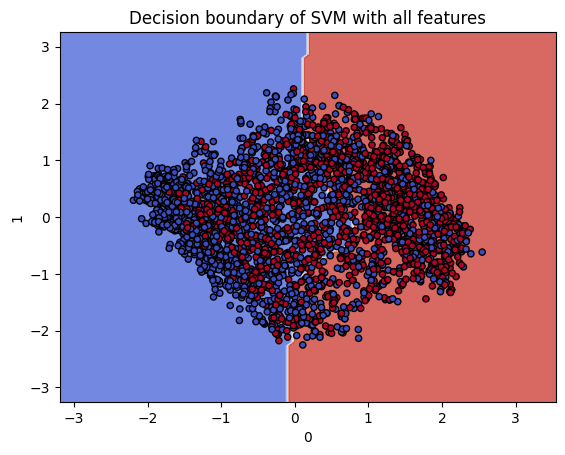

In [9]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_all, y_train_all,
    'SVM with all features'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_all{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - Mutual Information

### Training and score in the sample (80% - 0.01 std)

In [10]:
svm_mi = SVC(kernel='poly')
svm_mi_scores = cross_val_score(
    svm_mi,
    X_train_mi,
    y_train_mi['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_mi_scores.mean(),
    svm_mi_scores.std())
)

0.85 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [11]:
svm_mi = SVC(kernel='poly').fit(X_train_mi, y_train_mi['y'])
y_test_predict_mi = svm_mi.predict(X_test_mi)

print(classification_report(y_test_mi['y'], y_test_predict_mi))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       598
           1       0.80      0.91      0.85       562

    accuracy                           0.85      1160
   macro avg       0.85      0.85      0.85      1160
weighted avg       0.85      0.85      0.85      1160



### Decision boundary

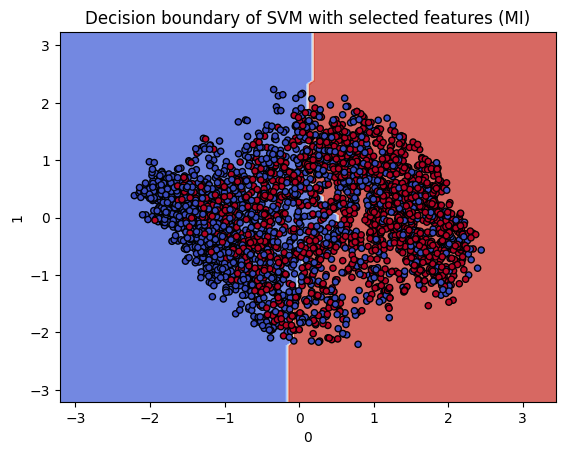

In [12]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_mi, y_train_mi,
    'SVM with selected features (MI)'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_mi{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - $\chi^2$

### Training and score in the sample (78% - 0.01 std)

In [13]:
svm_x2 = SVC(kernel='poly')
svm_x2_scores = cross_val_score(
    svm_x2,
    X_train_x2,
    y_train_x2['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_x2_scores.mean(),
    svm_x2_scores.std())
)

0.80 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [14]:
svm_x2 = SVC(kernel='poly').fit(X_train_x2, y_train_x2['y'])
y_test_predict_x2 = svm_x2.predict(X_test_x2)

print(classification_report(y_test_x2['y'], y_test_predict_x2))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       581
           1       0.79      0.84      0.81       579

    accuracy                           0.81      1160
   macro avg       0.81      0.81      0.81      1160
weighted avg       0.81      0.81      0.81      1160



### Decision boundary

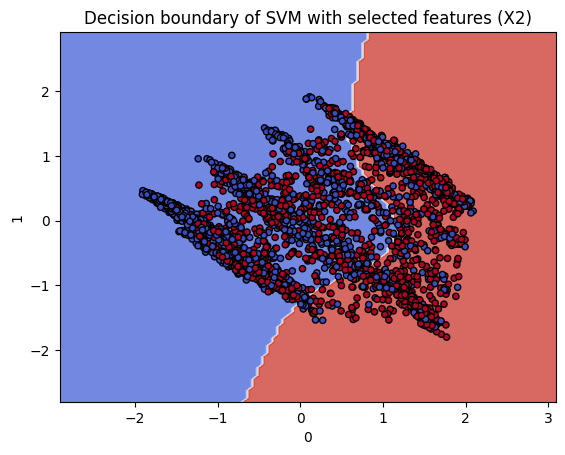

In [15]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_x2, y_train_x2,
    'SVM with selected features (X2)'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_x2{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - ANOVA

### Training and score in the sample (80% - 0.02 std)

In [16]:
svm_anova = SVC(kernel='poly')
svm_anova_scores = cross_val_score(
    svm_anova,
    X_train_anova,
    y_train_anova['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_anova_scores.mean(),
    svm_anova_scores.std())
)

0.82 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [17]:
svm_anova = SVC(kernel='poly').fit(X_train_anova, y_train_anova['y'])
y_test_predict_anova = svm_anova.predict(X_test_anova)

print(classification_report(y_test_anova['y'], y_test_predict_anova))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84       555
           1       0.84      0.91      0.87       605

    accuracy                           0.86      1160
   macro avg       0.86      0.86      0.86      1160
weighted avg       0.86      0.86      0.86      1160



### Decision boundary

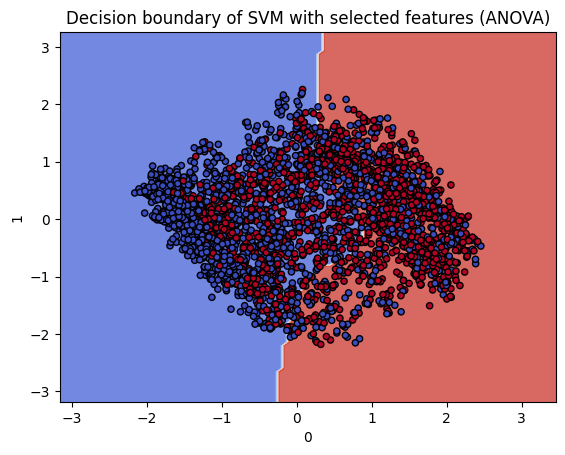

In [18]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_anova, y_train_anova,
    'SVM with selected features (ANOVA)'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_anova{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Multivariate - Relief

### Training and score in the sample (78% - 0.1 std)

In [19]:
svm_relief = SVC(kernel='poly')
svm_relief_scores = cross_val_score(
    svm_relief,
    X_train_relief,
    y_train_relief['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_relief_scores.mean(),
    svm_relief_scores.std())
)

0.79 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [20]:
svm_relief = SVC(kernel='poly').fit(X_train_relief, y_train_relief['y'])
y_test_predict_relief = svm_relief.predict(X_test_relief)

print(classification_report(y_test_relief['y'], y_test_predict_relief))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       584
           1       0.77      0.85      0.81       576

    accuracy                           0.80      1160
   macro avg       0.81      0.80      0.80      1160
weighted avg       0.81      0.80      0.80      1160



### Decision boundary

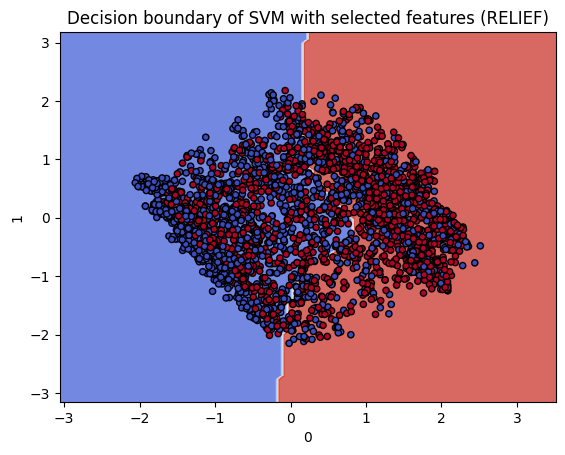

In [21]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_relief, y_train_relief,
    'SVM with selected features (RELIEF)'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_relief{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Wrapper

### Select features

In [22]:
if RUN_WRAPPER_SELECTION:
    svm_wrapper = SVC(kernel='poly')

    svm_fs_wrapper = SequentialFeatureSelectorTransformer(
        svm_wrapper, n_features_to_select=75)

    print('Fitting model. This may take a while...')
    X_svm_wrapper = svm_fs_wrapper.fit_transform(X_all, y['y'])
    print('We have a winner!')

    X_train_svm_wrapper, X_test_svm_wrapper, y_train_svm_wrapper, y_test_svm_wrapper = split_train_test(X_svm_wrapper, y)

    X_svm_wrapper.to_parquet(STAGE_DIR / 'selection' / f'X_train_svm{SUFIX}.parquet')

### Training and score in the sample (80% - 0.1 std)

In [23]:
if not RUN_WRAPPER_SELECTION:
    X_svm_wrapper = pd.read_parquet(STAGE_DIR / 'selection' / f'X_train_svm{SUFIX}.parquet')
    X_train_svm_wrapper, X_test_svm_wrapper, y_train_svm_wrapper, y_test_svm_wrapper = split_train_test(X_svm_wrapper, y)

In [25]:
svm_wrapper = SVC(kernel='poly')

svm_wrapper_scores = cross_val_score(
    svm_wrapper,
    X_train_svm_wrapper,
    y_train_svm_wrapper['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    svm_wrapper_scores.mean(),
    svm_wrapper_scores.std())
)

0.84 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [26]:
svm_wrapper = SVC(kernel='poly').fit(X_train_svm_wrapper, y_train_svm_wrapper['y'])
y_test_predict_svm_wrapper = svm_wrapper.predict(X_test_svm_wrapper)

print(classification_report(y_test_svm_wrapper['y'], y_test_predict_svm_wrapper))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       583
           1       0.81      0.88      0.84       577

    accuracy                           0.84      1160
   macro avg       0.84      0.84      0.84      1160
weighted avg       0.84      0.84      0.84      1160



### Decision boundary

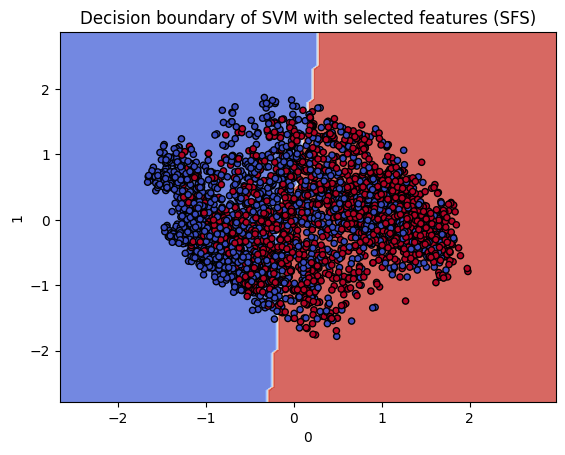

In [27]:
decision_boundary_plot(
    SVC(kernel='poly'),
    X_train_svm_wrapper, y_train_svm_wrapper,
    'SVM with selected features (SFS)'
)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'db_svm_wrapper{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Metrics summary

In [28]:
y_true_prediction_svm = [
    (y_test_all, y_test_predict_all),
    (y_test_mi, y_test_predict_mi),
    (y_test_x2, y_test_predict_x2),
    (y_test_anova, y_test_predict_anova),
    (y_test_relief, y_test_predict_relief),
    (y_test_svm_wrapper, y_test_predict_svm_wrapper),
]

metrics_svm_summary = pd.DataFrame(
    [precision_recall_fscore_support(y_true, y_predict, average='macro')[:-1]
     for y_true, y_predict in y_true_prediction_svm],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Precision', 'Recall', 'F-score'
    ]
)

metrics_svm_summary

Precision    Recall   F-score
All features         0.842851  0.837938  0.838042
Mutual information   0.850899  0.847603  0.845497
Chi squared          0.808349  0.806955  0.806689
ANOVA                0.861135  0.855595  0.856672
RELIEF               0.806640  0.803796  0.803053
Wrapper              0.840591  0.838981  0.838629

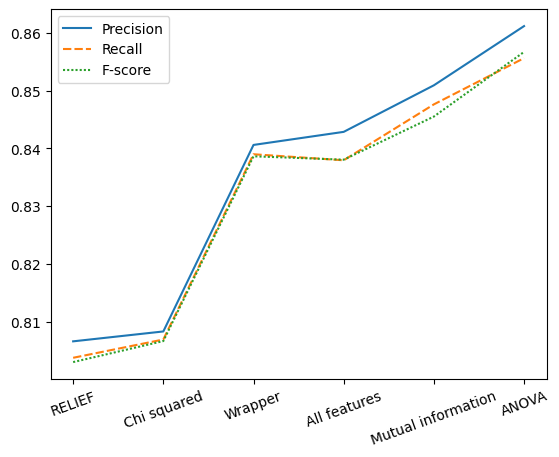

In [29]:
sns.lineplot(
    metrics_svm_summary.sort_values(['Precision', 'Recall', 'F-score']),
)
plt.xticks(rotation=20)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'metrics' / f'metrics_svm{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [ ]:
accuracy_svm_summary = pd.DataFrame(
    [accuracy_score(y_true, y_predict)
     for y_true, y_predict in y_true_prediction_svm],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Accuracy'
    ]
) * 100

print(accuracy_svm_summary.round(2).to_latex())

## Decision boundary summary

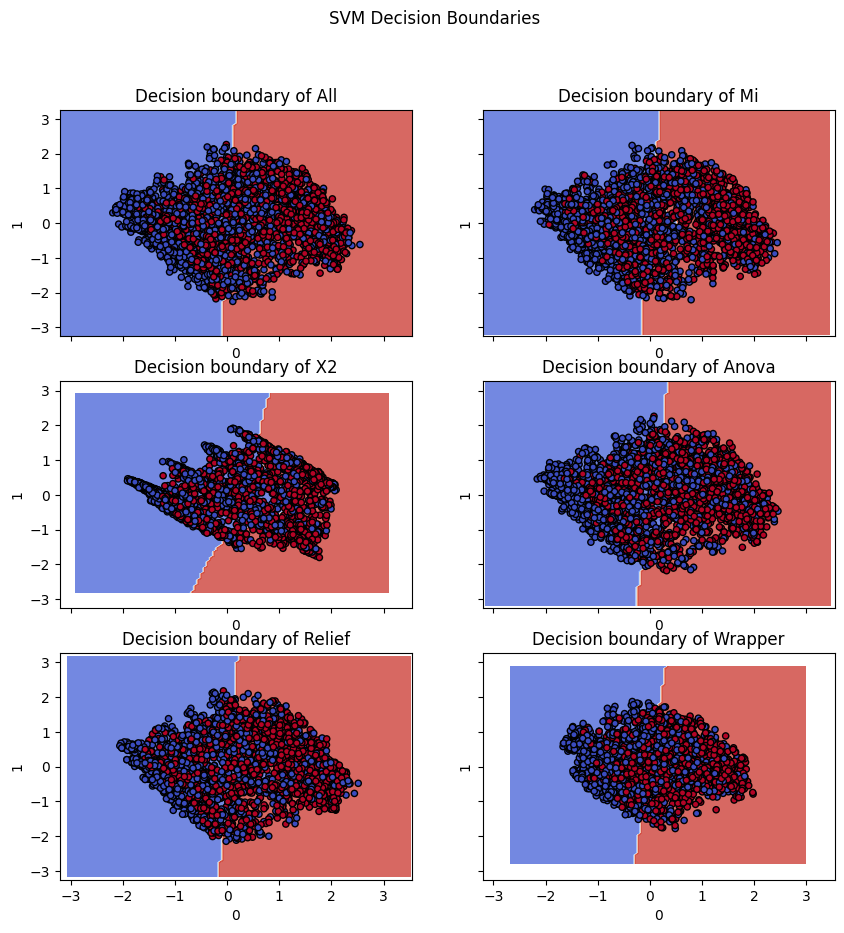

In [30]:
db_informations = [
    ('all', X_train_all, y_train_all),
    ('mi', X_train_mi, y_train_mi),
    ('x2', X_train_x2, y_train_x2),
    ('anova', X_train_anova, y_train_anova),
    ('relief', X_train_relief, y_train_relief),
    ('wrapper', X_train_svm_wrapper, y_train_svm_wrapper),
]

fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.suptitle('SVM Decision Boundaries')
for i, (name, X_train, y_train) in enumerate(db_informations):
    r, c = i // 2, i % 2
    decision_boundary_plot(
        SVC(kernel='poly'),
        X_train, y_train,
        name.title(),
        ax=axs[r][c]
    )

# Classification Tree

We use a Decision Tree model with entropy criterion and 10 levels of depth. The in-sample scores are calculated using a cross validation method with 5 folds. The accuracy is used as the metric to evaluate the model performance.

In [31]:
tree_parameters = {
    'criterion': 'entropy',
    'max_depth': 5
}

## All features

### Training and score in the sample (78% - 0.00 std)

In [32]:
tree_all = DecisionTreeClassifier(**tree_parameters)
tree_all_scores = cross_val_score(
    tree_all,
    X_train_all,
    y_train_all['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_all_scores.mean(),
    tree_all_scores.std())
)

0.78 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [33]:
tree_all = DecisionTreeClassifier(**tree_parameters).fit(X_train_all, y_train_all['y'])
y_test_predict_tree_all = tree_all.predict(X_test_all)

print(classification_report(y_test_all['y'], y_test_predict_tree_all))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       571
           1       0.77      0.77      0.77       589

    accuracy                           0.77      1160
   macro avg       0.77      0.77      0.77      1160
weighted avg       0.77      0.77      0.77      1160



### Tree structure

In [34]:
tree_structure(tree_all, X_train_all.columns.values)

The binary tree structure has 49 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, scholarship_years_sqd_mean] <= 0.17599248886108398 else to node 30.
	node=1 is a split node: go to node 2 if X[:, dependency_rate_sqd] <= 0.003945930395275354 else to node 17.
		node=2 is a split node: go to node 3 if X[:, state_floor_good] <= 0.9841720759868622 else to node 10.
			node=3 is a split node: go to node 4 if X[:, education_secondary_incomplete] <= 0.9767048060894012 else to node 7.
				node=4 is a split node: go to node 5 if X[:, state_floor_good] <= 0.012703502550721169 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a split node: go to node 8 if X[:, age_mean] <= 0.23900292813777924 else to node 9.
					node=8 is a leaf node.
					node=9 is a leaf node.
			node=10 is a split node: go to node 11 if X[:, mobile_phone_number] <= 0.2858775705099106 else to node 14.
				node=11 is a split node: go to node 12 if X[:, d

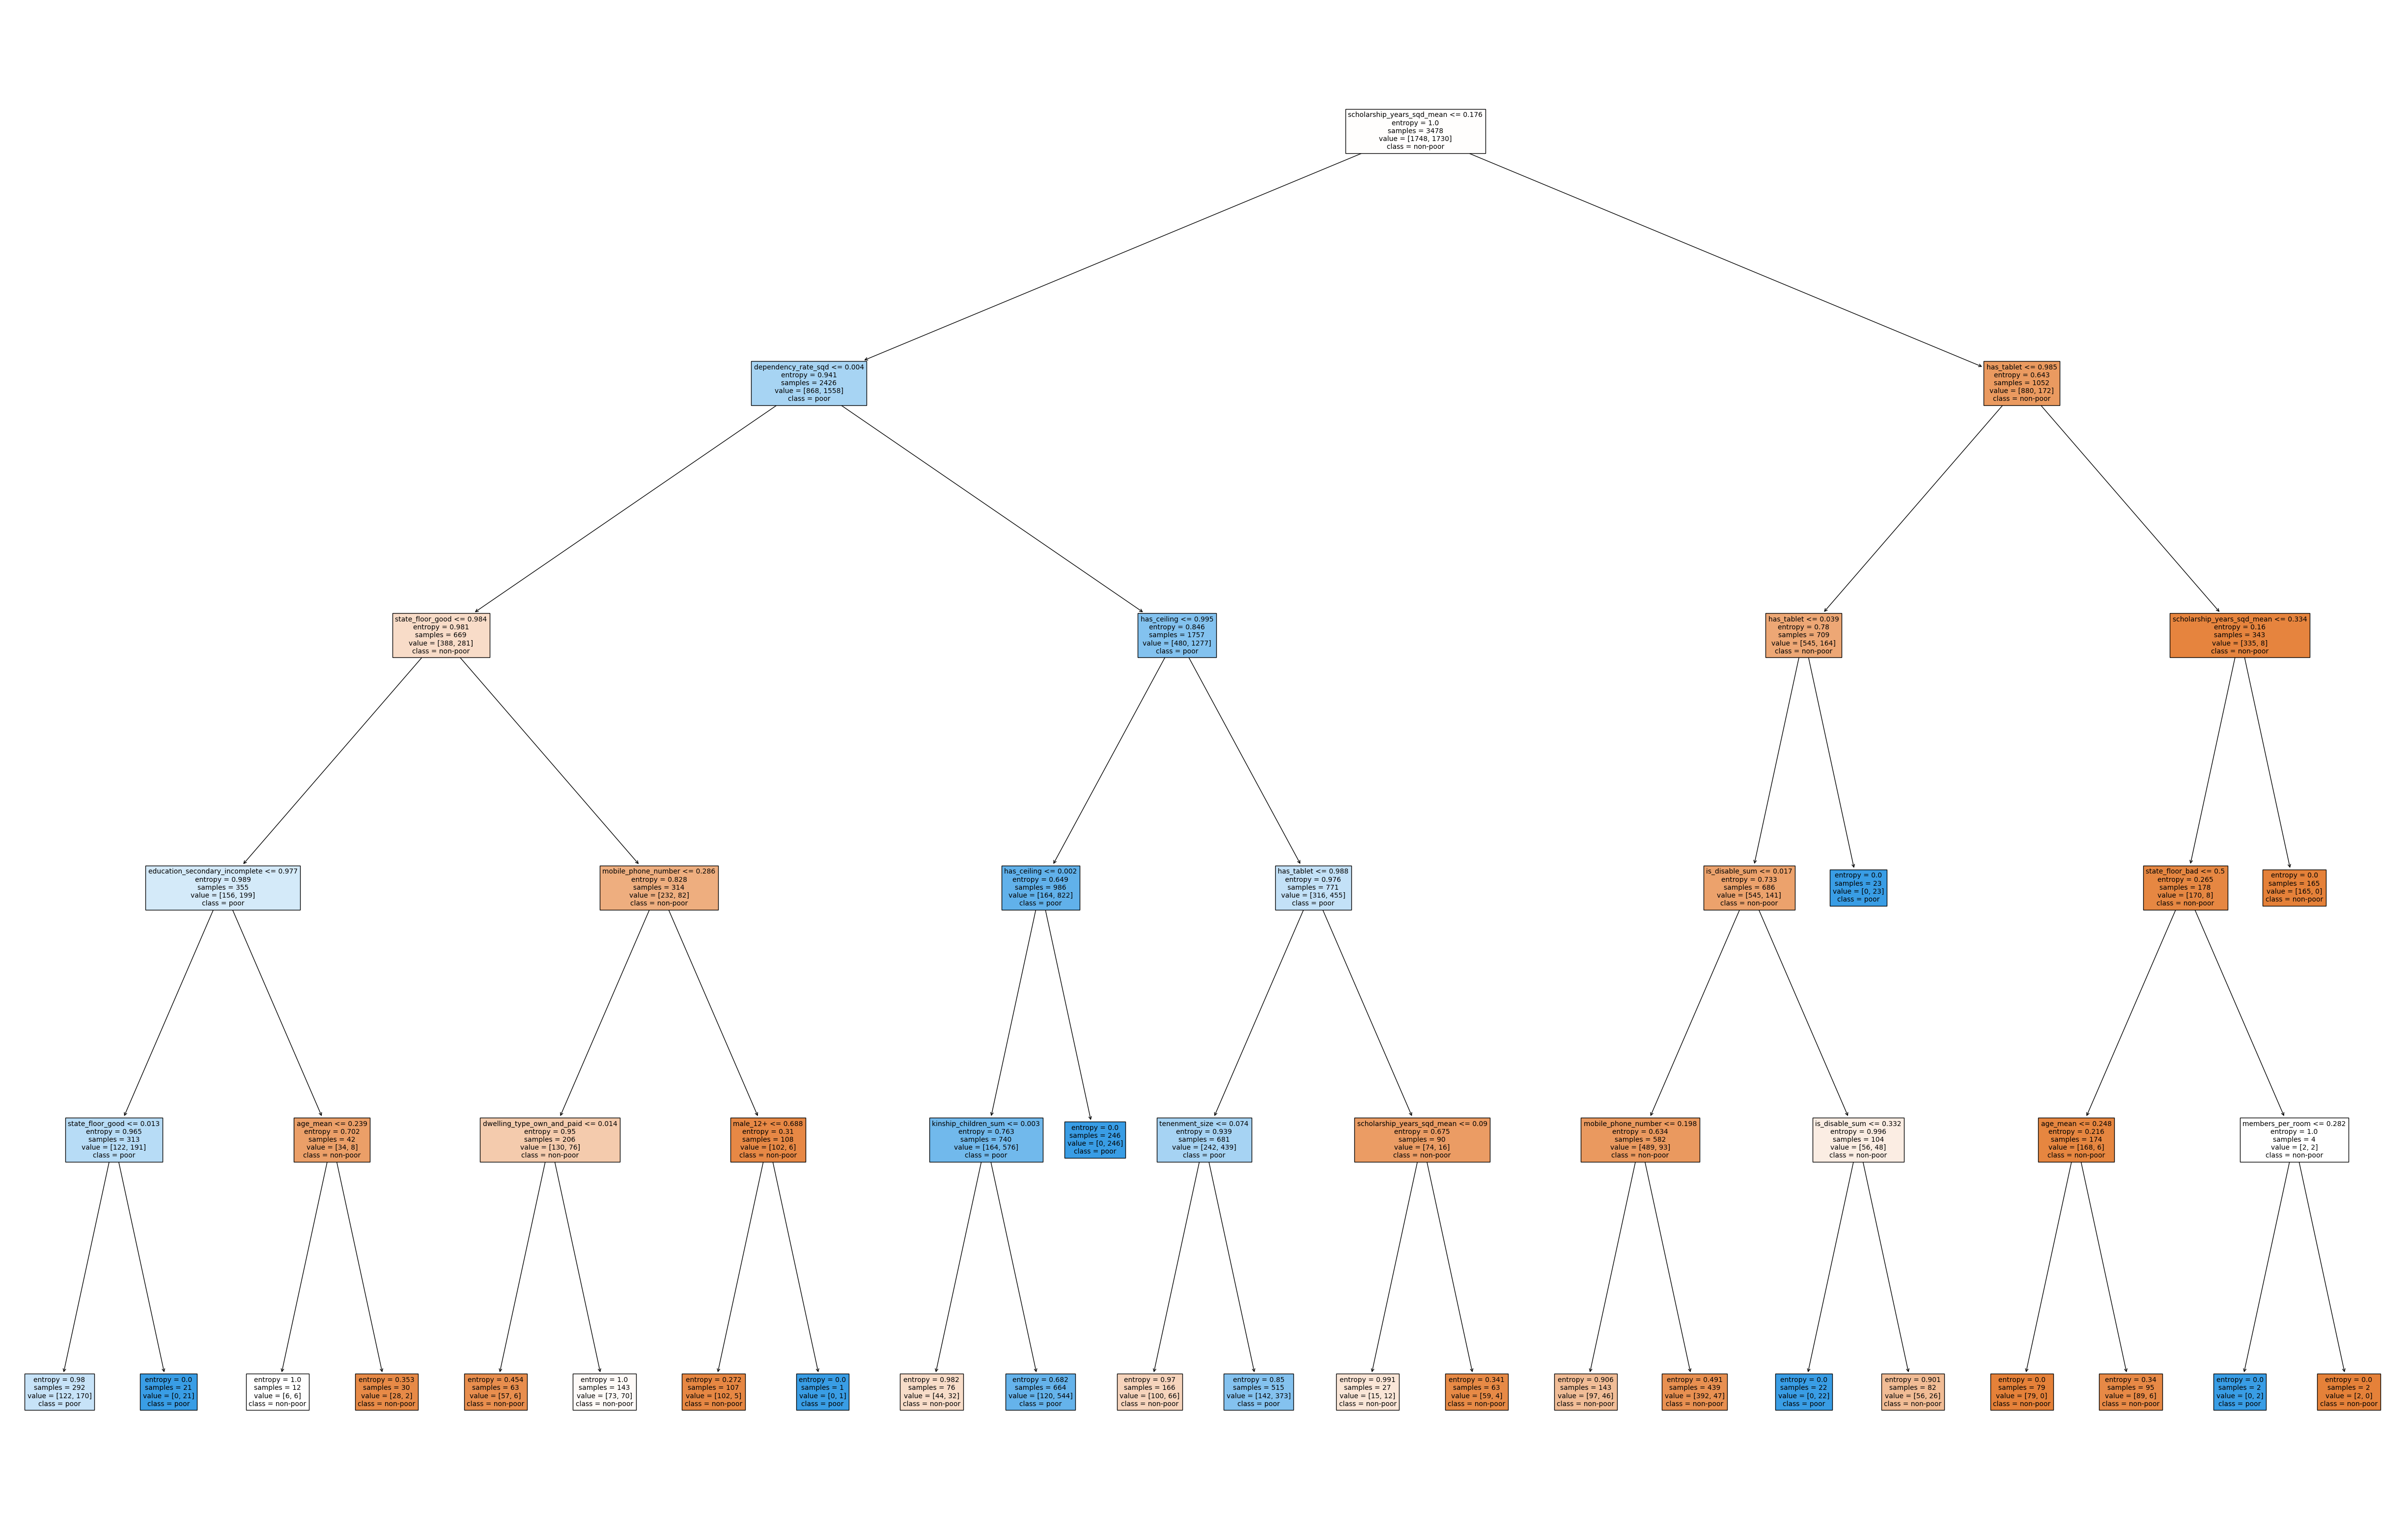

In [35]:
fig = plt.figure(figsize=(63, 40))
_ = plot_tree(tree_all,
              feature_names=X_train_all.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [36]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_all{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - Mutual Information

### Training and score in the sample (78% - 0.01 std)

In [37]:
tree_mi = DecisionTreeClassifier(**tree_parameters)
tree_mi_scores = cross_val_score(
    tree_mi,
    X_train_mi,
    y_train_mi['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_mi_scores.mean(),
    tree_mi_scores.std())
)

0.76 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [38]:
tree_mi = DecisionTreeClassifier(**tree_parameters).fit(X_train_mi, y_train_mi['y'])
y_test_predict_tree_mi = tree_mi.predict(X_test_mi)

print(classification_report(y_test_mi['y'], y_test_predict_tree_mi))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       598
           1       0.78      0.78      0.78       562

    accuracy                           0.79      1160
   macro avg       0.79      0.79      0.79      1160
weighted avg       0.79      0.79      0.79      1160



### Tree structure

In [39]:
tree_structure(tree_mi, X_train_mi.columns.values)

The binary tree structure has 45 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, scholarship_years_sqd_mean] <= 0.16977334022521973 else to node 26.
	node=1 is a split node: go to node 2 if X[:, dependency_rate_sqd] <= 0.003945930395275354 else to node 13.
		node=2 is a split node: go to node 3 if X[:, monthly_rent] <= 0.04079071059823036 else to node 10.
			node=3 is a split node: go to node 4 if X[:, education_secondary_incomplete] <= 0.9767048060894012 else to node 7.
				node=4 is a split node: go to node 5 if X[:, mobile_phone_number] <= 0.1977287456393242 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a split node: go to node 8 if X[:, civil_state_married] <= 0.5 else to node 9.
					node=8 is a leaf node.
					node=9 is a leaf node.
			node=10 is a split node: go to node 11 if X[:, number_rooms] <= 0.15000000223517418 else to node 12.
				node=11 is a leaf node.
				node=12 is a leaf node.
		node=13

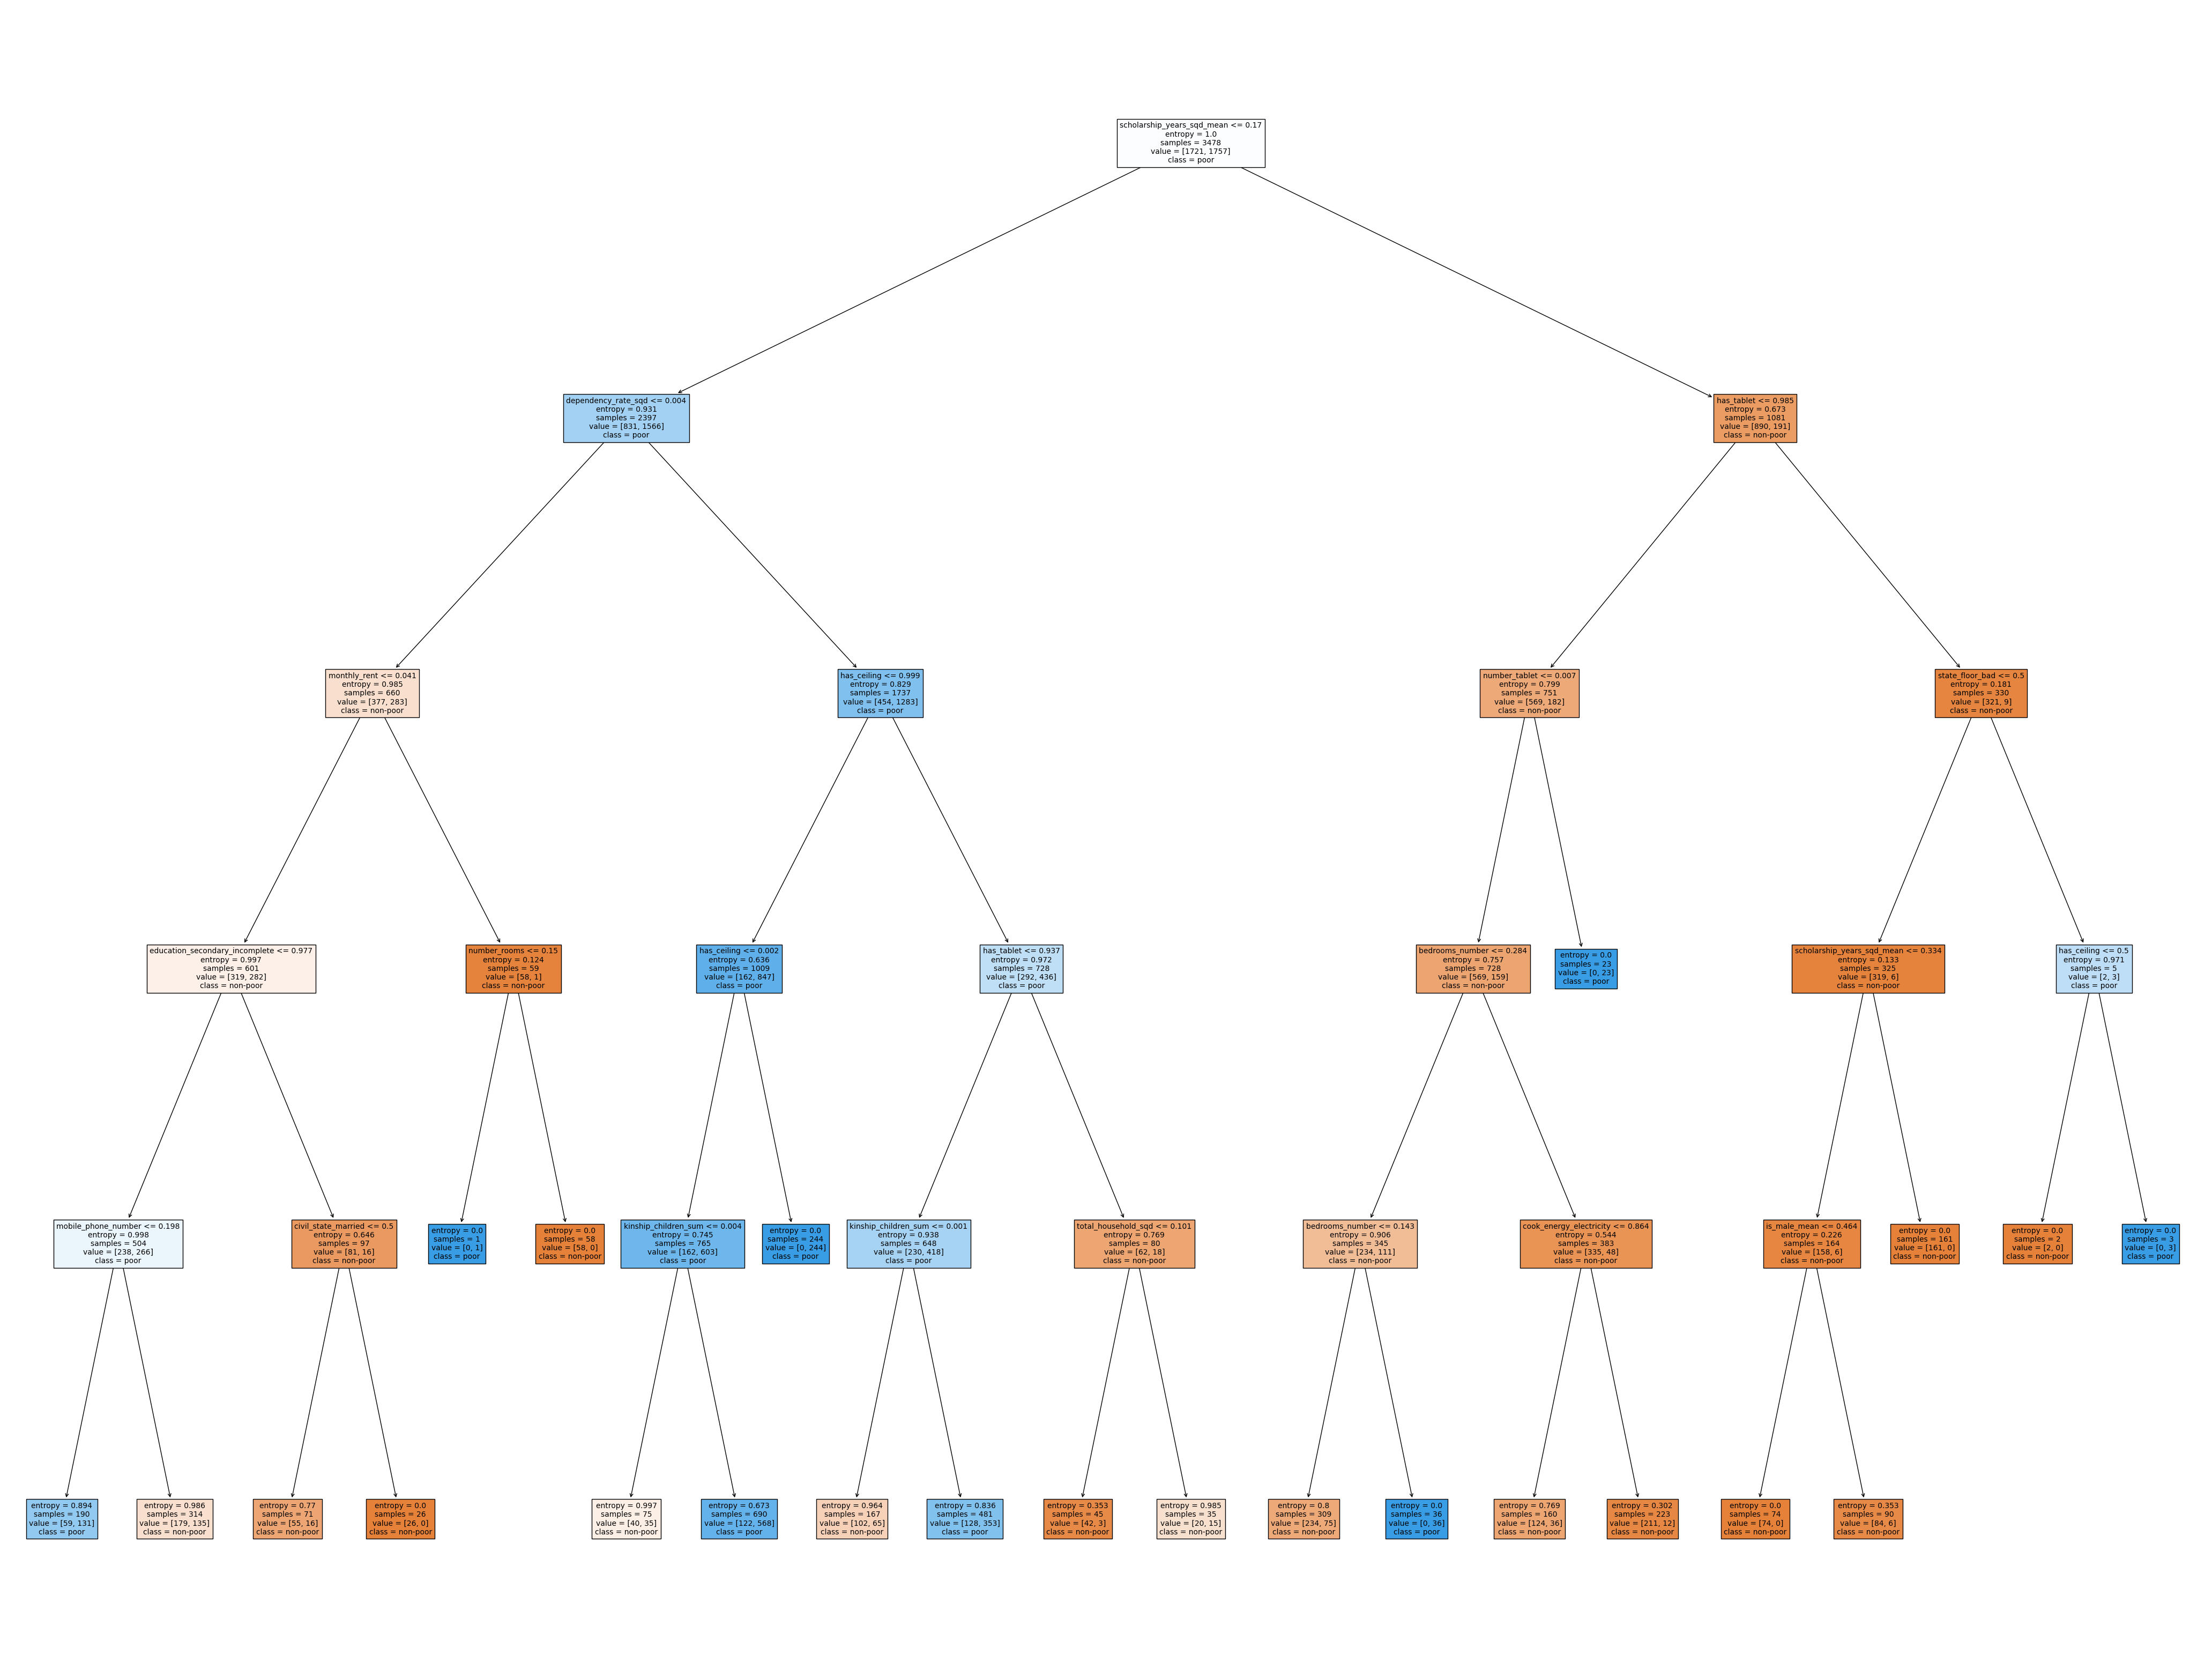

In [40]:
fig = plt.figure(figsize=(53, 40))
_ = plot_tree(tree_mi,
              feature_names=X_train_mi.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [41]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_mi{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - $\chi^2$

### Training and score in the sample (78% - 0.01 std)

In [42]:
tree_x2 = DecisionTreeClassifier(**tree_parameters)
tree_x2_scores = cross_val_score(
    tree_x2,
    X_train_x2,
    y_train_x2['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_x2_scores.mean(),
    tree_x2_scores.std())
)

0.75 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [43]:
tree_x2 = DecisionTreeClassifier(
        **tree_parameters
    ).fit(X_train_x2, y_train_x2['y'])
y_test_predict_tree_x2 = tree_x2.predict(X_test_x2)

print(classification_report(y_test_x2['y'], y_test_predict_tree_x2))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       581
           1       0.76      0.74      0.75       579

    accuracy                           0.76      1160
   macro avg       0.76      0.76      0.76      1160
weighted avg       0.76      0.76      0.76      1160



### Tree structure

In [44]:
tree_structure(tree_x2, X_train_x2.columns.values)

The binary tree structure has 47 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, scholarship_years_sqd_mean] <= 0.17798008024692535 else to node 26.
	node=1 is a split node: go to node 2 if X[:, has_ceiling] <= 0.9988287091255188 else to node 11.
		node=2 is a split node: go to node 3 if X[:, has_ceiling] <= 0.0016367316711694002 else to node 10.
			node=3 is a split node: go to node 4 if X[:, male_head_education_years] <= 0.28456518054008484 else to node 7.
				node=4 is a split node: go to node 5 if X[:, member_12-] <= 0.0002592533128336072 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a split node: go to node 8 if X[:, children_19-_mean] <= 0.11252261325716972 else to node 9.
					node=8 is a leaf node.
					node=9 is a leaf node.
			node=10 is a leaf node.
		node=11 is a split node: go to node 12 if X[:, has_tablet] <= 0.9881279170513153 else to node 19.
			node=12 is a split node: go to node 13 if X[

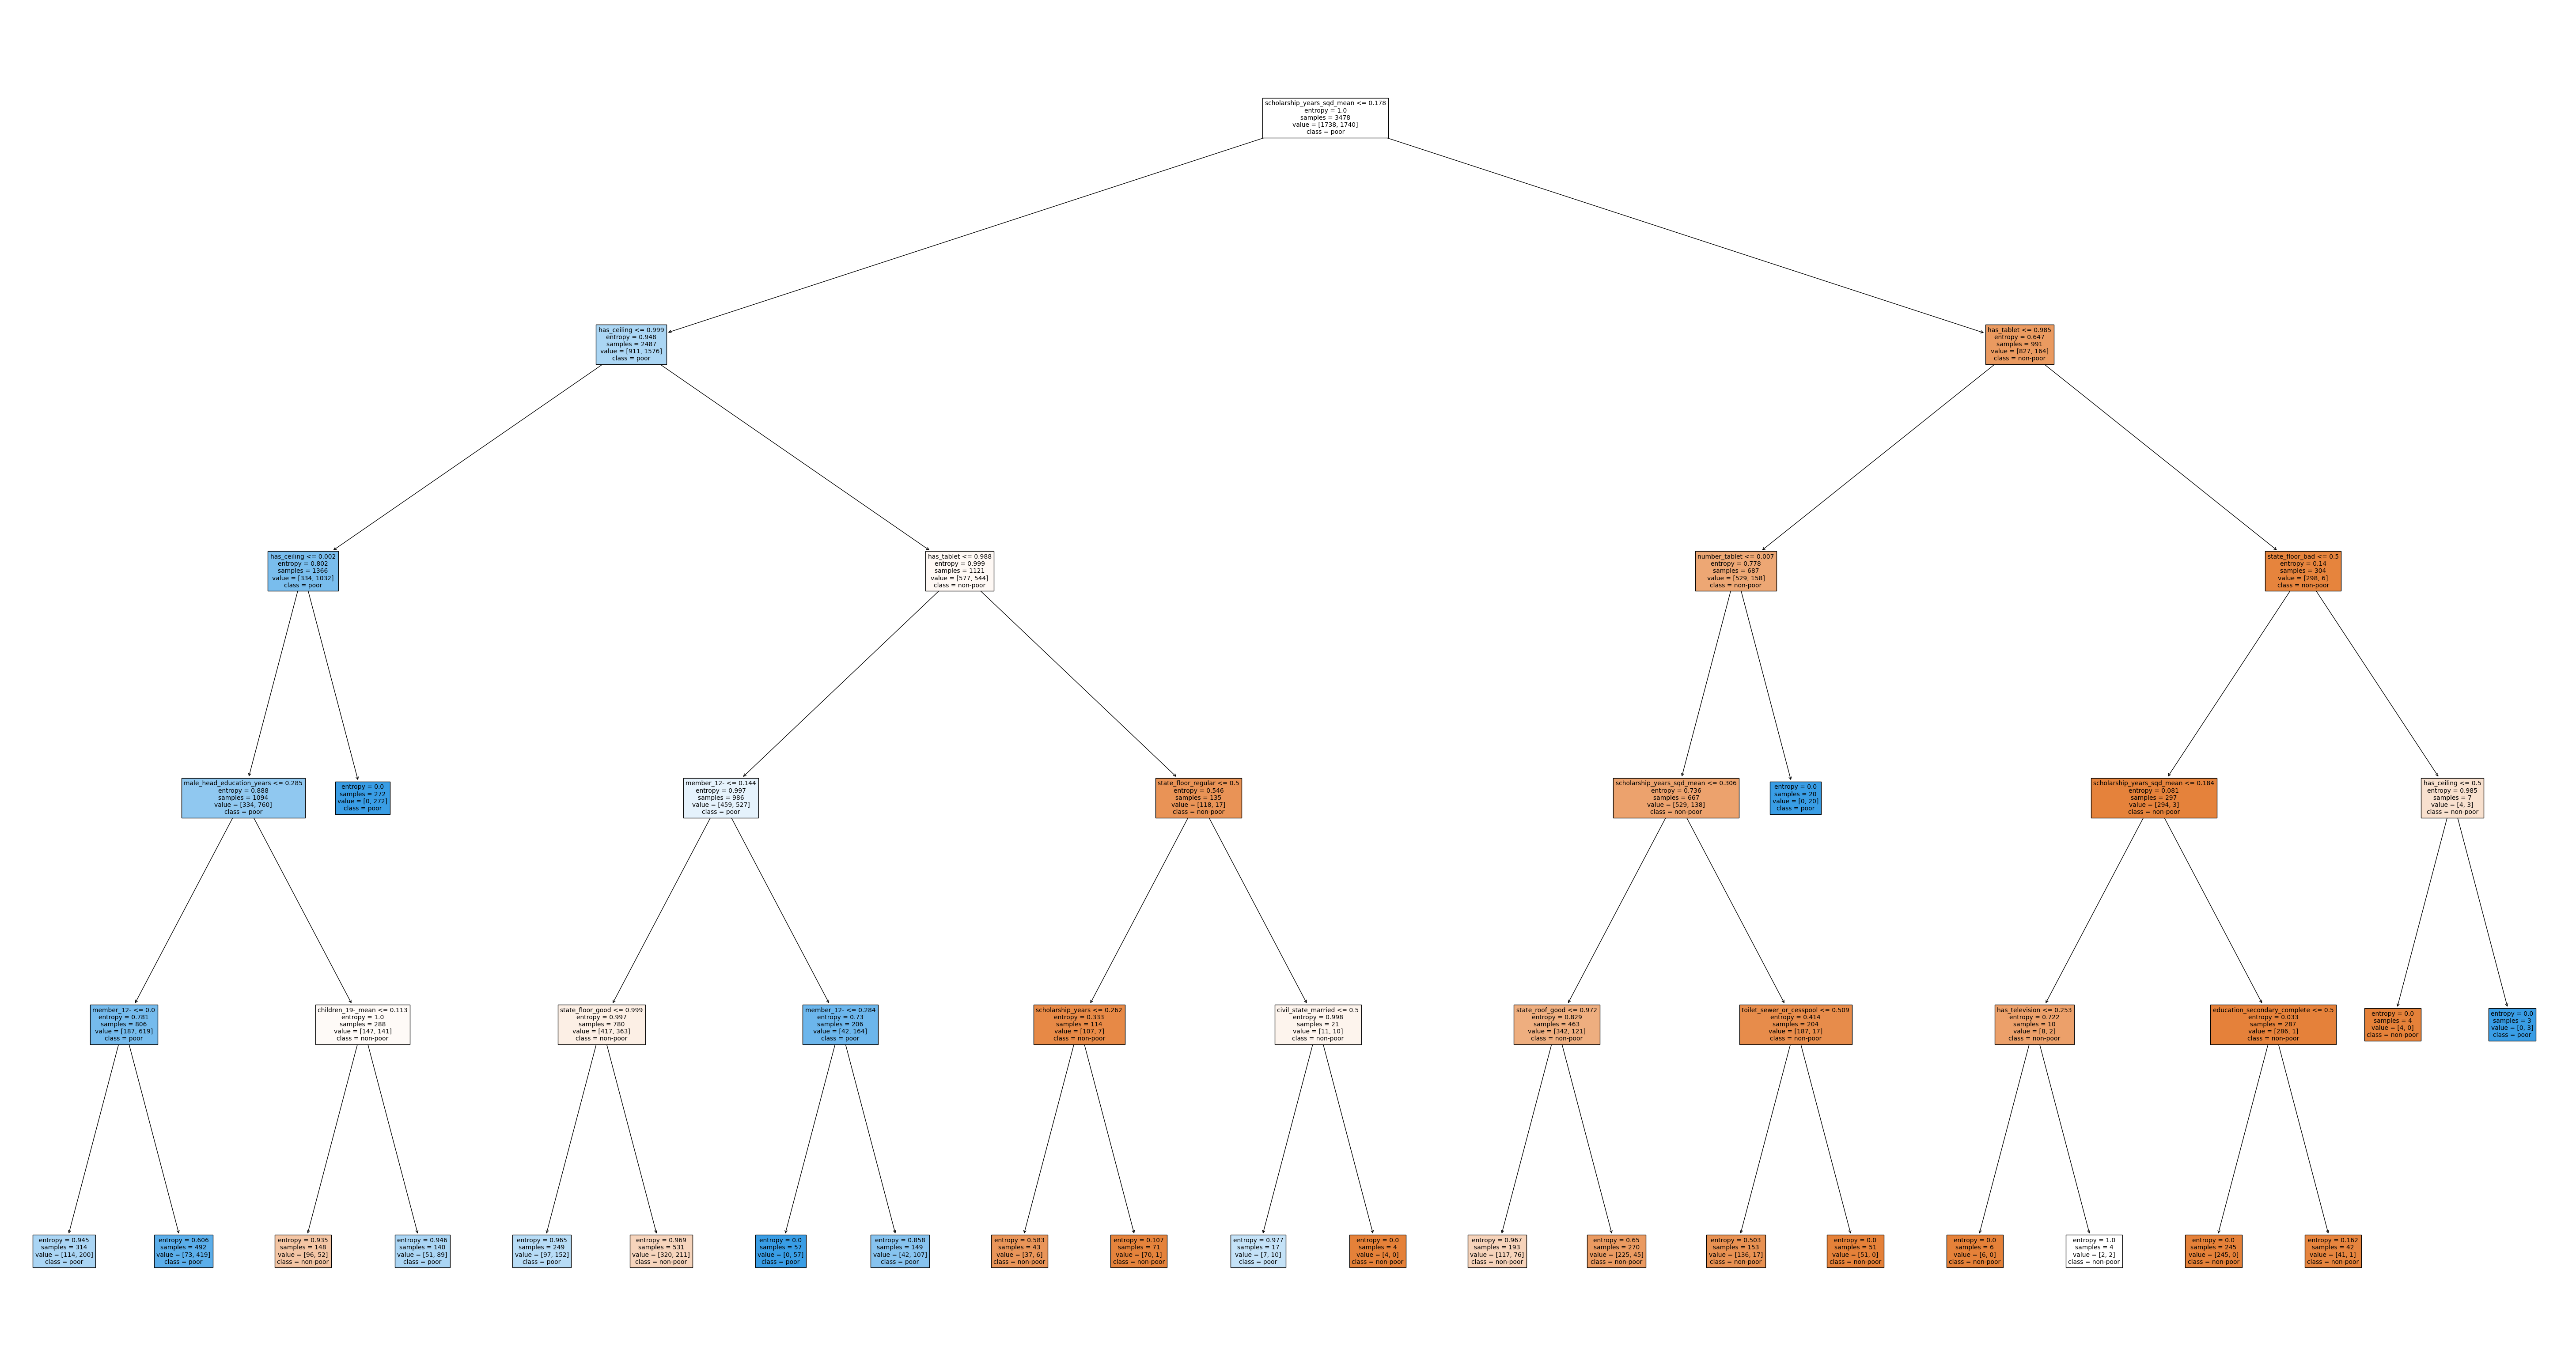

In [45]:
fig = plt.figure(figsize=(75, 40))
_ = plot_tree(tree_x2,
              feature_names=X_train_x2.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [46]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_x2{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Univariate - ANOVA

### Training and score in the sample (78% - 0.01 std)

In [47]:
tree_anova = DecisionTreeClassifier(**tree_parameters)
tree_anova_scores = cross_val_score(
    tree_anova,
    X_train_anova,
    y_train_anova['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_anova_scores.mean(),
    tree_anova_scores.std())
)

0.77 accuracy with a standard deviation of 0.02


### Out-of-sample score

In [48]:
tree_anova = DecisionTreeClassifier(
    **tree_parameters
).fit(X_train_anova, y_train_anova['y'])
y_test_predict_tree_anova = tree_anova.predict(X_test_anova)

print(classification_report(y_test_anova['y'], y_test_predict_tree_anova))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       555
           1       0.80      0.78      0.79       605

    accuracy                           0.78      1160
   macro avg       0.78      0.78      0.78      1160
weighted avg       0.78      0.78      0.78      1160



### Tree structure

In [49]:
tree_structure(tree_anova, X_train_anova.columns.values)

The binary tree structure has 47 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, scholarship_years_sqd_mean] <= 0.17005356401205063 else to node 30.
	node=1 is a split node: go to node 2 if X[:, dependency_rate] <= 0.12502150237560272 else to node 15.
		node=2 is a split node: go to node 3 if X[:, state_floor_good] <= 0.9984795153141022 else to node 8.
			node=3 is a split node: go to node 4 if X[:, state_floor_good] <= 0.012703502550721169 else to node 7.
				node=4 is a split node: go to node 5 if X[:, mobile_phone_number] <= 0.19902707636356354 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a leaf node.
			node=8 is a split node: go to node 9 if X[:, is_disable_mean] <= 0.01162021141499281 else to node 12.
				node=9 is a split node: go to node 10 if X[:, state_roof_bad] <= 0.04216392710804939 else to node 11.
					node=10 is a leaf node.
					node=11 is a leaf node.
				node=12 is a split node: go to n

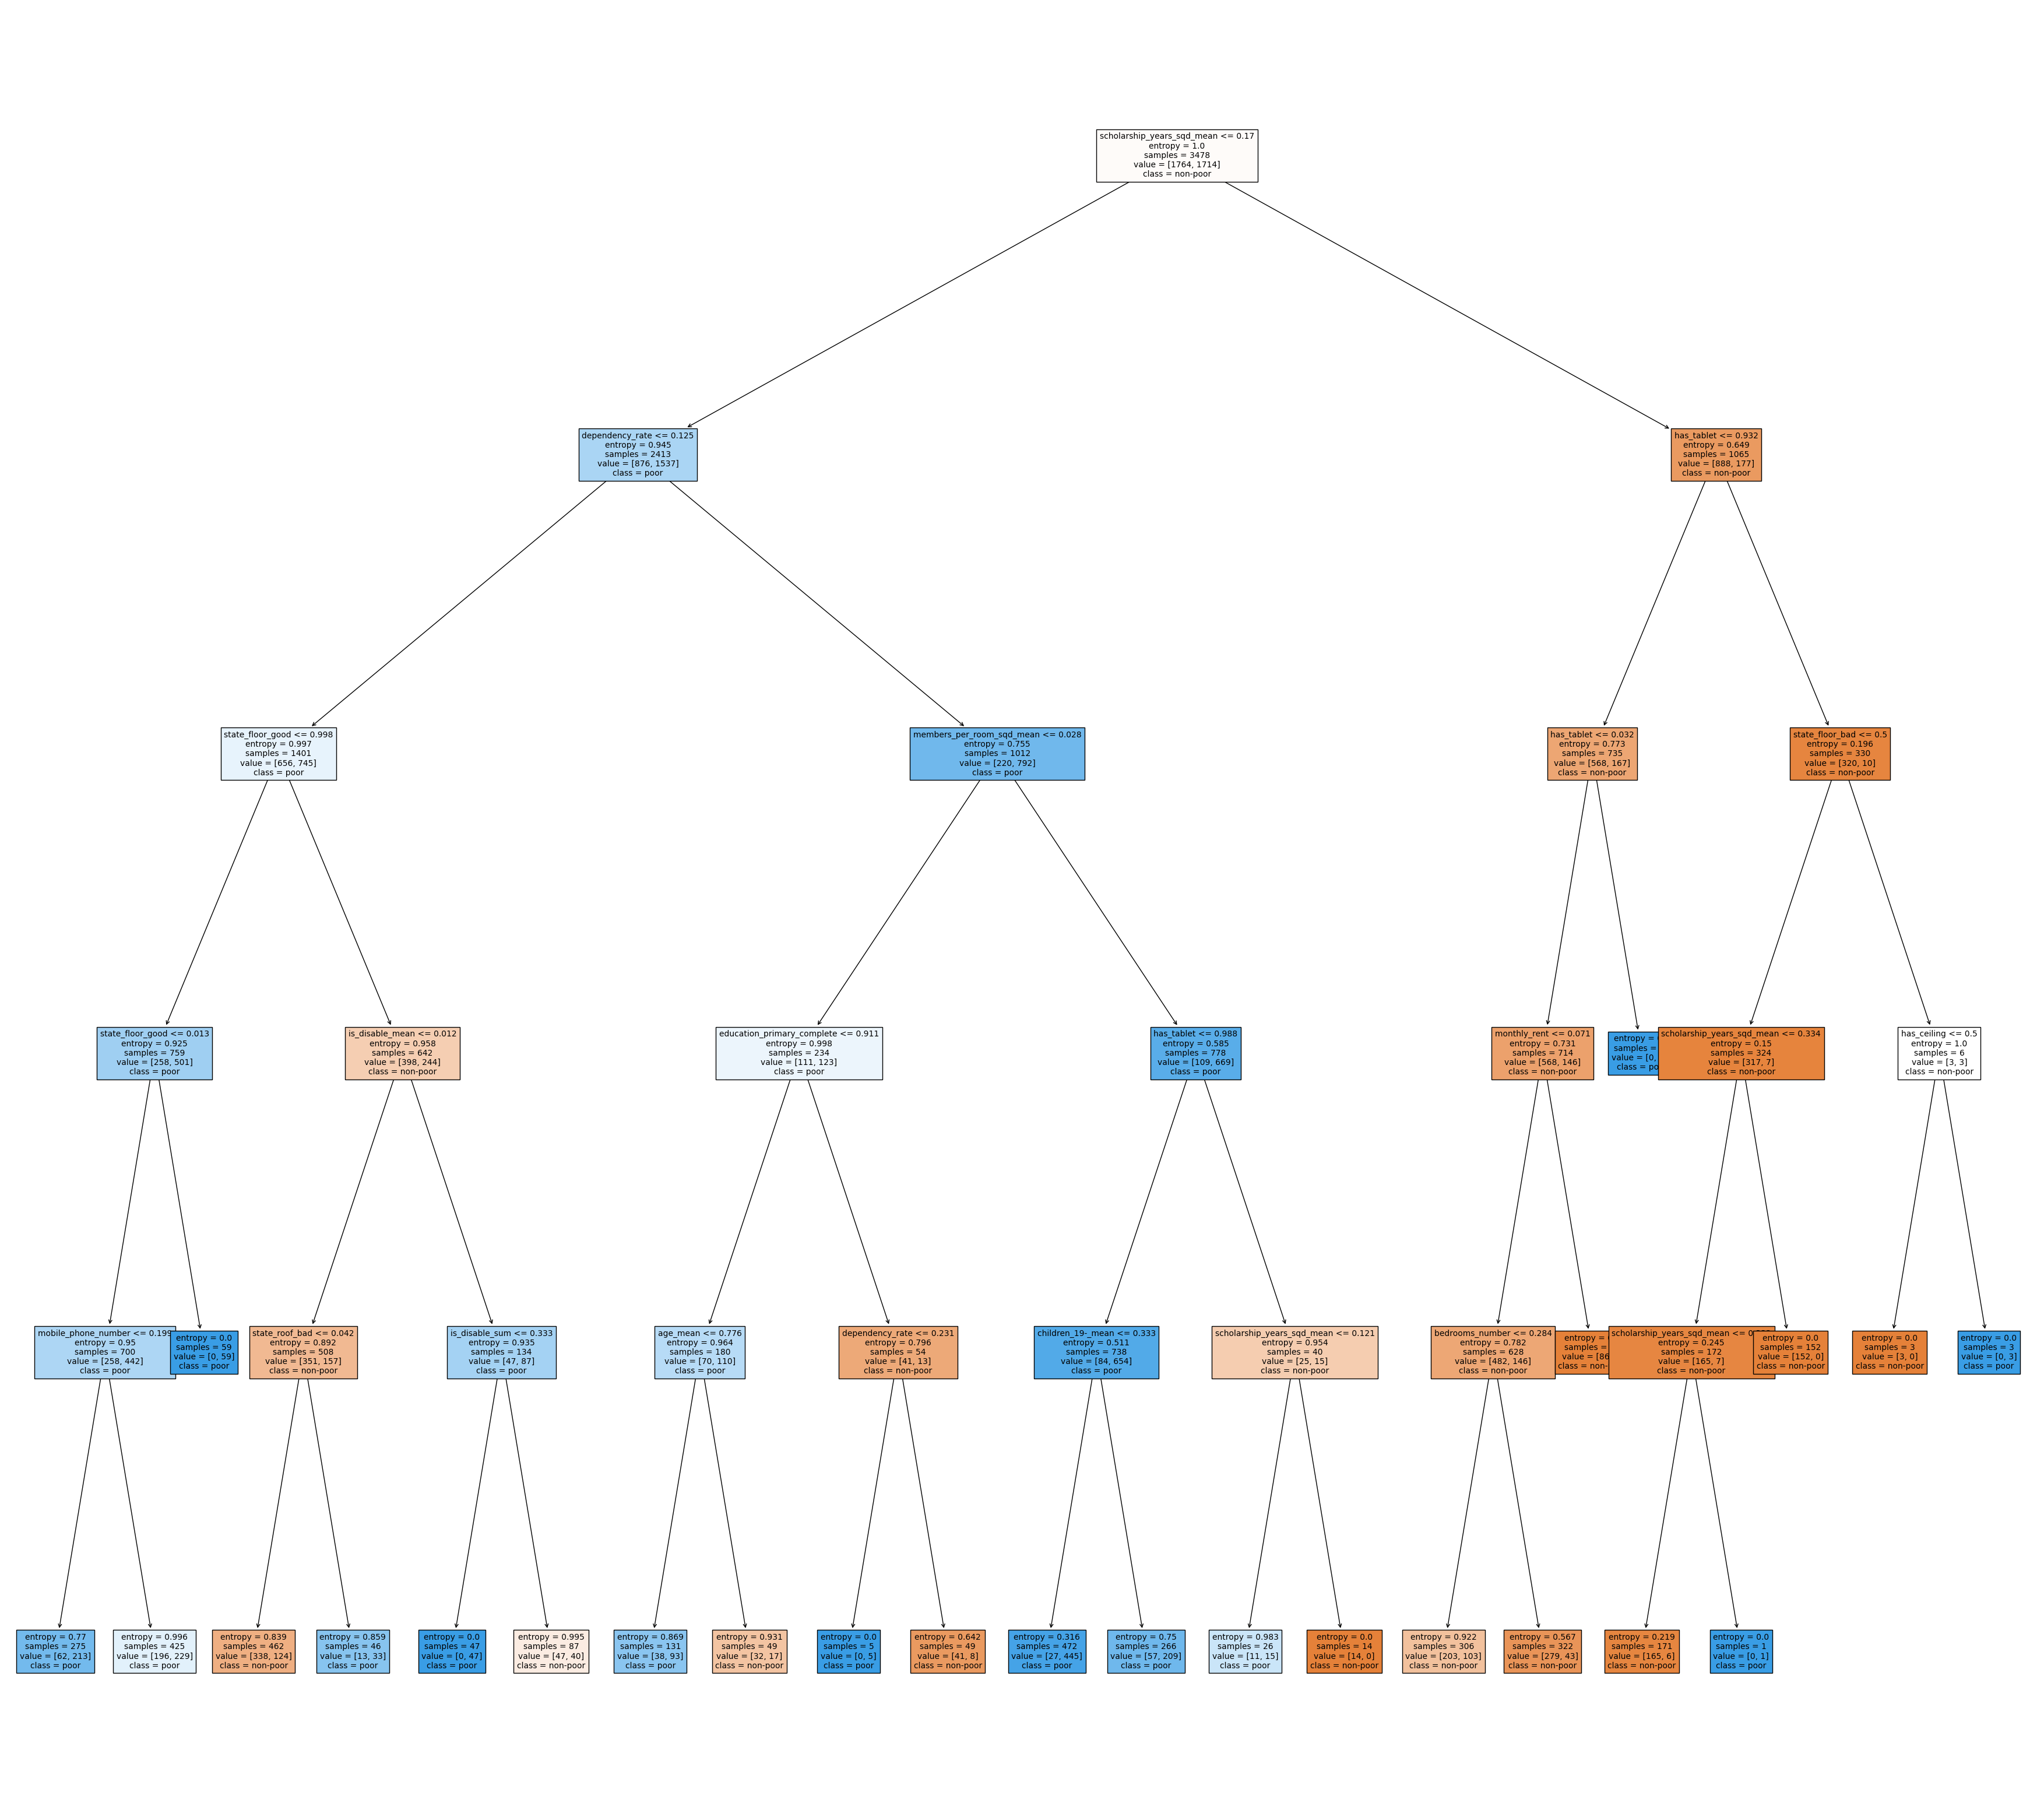

In [50]:
fig = plt.figure(figsize=(45, 40))
_ = plot_tree(tree_anova,
              feature_names=X_train_anova.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [51]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_anova{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Multivariate - Relief

### Training and score in the sample (77% - 0.01 std)

In [52]:
tree_relief = DecisionTreeClassifier(**tree_parameters)
tree_relief_scores = cross_val_score(
    tree_relief,
    X_train_relief,
    y_train_relief['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_relief_scores.mean(),
    tree_relief_scores.std())
)

0.74 accuracy with a standard deviation of 0.02


### Out-of-sample score

In [53]:
tree_relief = DecisionTreeClassifier(**tree_parameters).fit(X_train_relief, y_train_relief['y'])
y_test_predict_tree_relief = tree_relief.predict(X_test_relief)

print(classification_report(y_test_relief['y'], y_test_predict_tree_relief))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72       584
           1       0.71      0.80      0.75       576

    accuracy                           0.74      1160
   macro avg       0.74      0.74      0.74      1160
weighted avg       0.74      0.74      0.74      1160



### Tree structure

In [54]:
tree_structure(tree_relief, X_train_relief.columns.values)

The binary tree structure has 39 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, has_ceiling] <= 0.9988287091255188 else to node 18.
	node=1 is a split node: go to node 2 if X[:, has_ceiling] <= 0.0016367316711694002 else to node 17.
		node=2 is a split node: go to node 3 if X[:, state_floor_good] <= 0.9984795153141022 else to node 10.
			node=3 is a split node: go to node 4 if X[:, state_floor_regular] <= 0.9865437150001526 else to node 7.
				node=4 is a split node: go to node 5 if X[:, state_floor_bad] <= 0.9872964918613434 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a split node: go to node 8 if X[:, civil_state_married] <= 0.9959781169891357 else to node 9.
					node=8 is a leaf node.
					node=9 is a leaf node.
			node=10 is a split node: go to node 11 if X[:, has_tablet] <= 0.7076346427202225 else to node 14.
				node=11 is a split node: go to node 12 if X[:, education_secondary_complete] <= 0.94

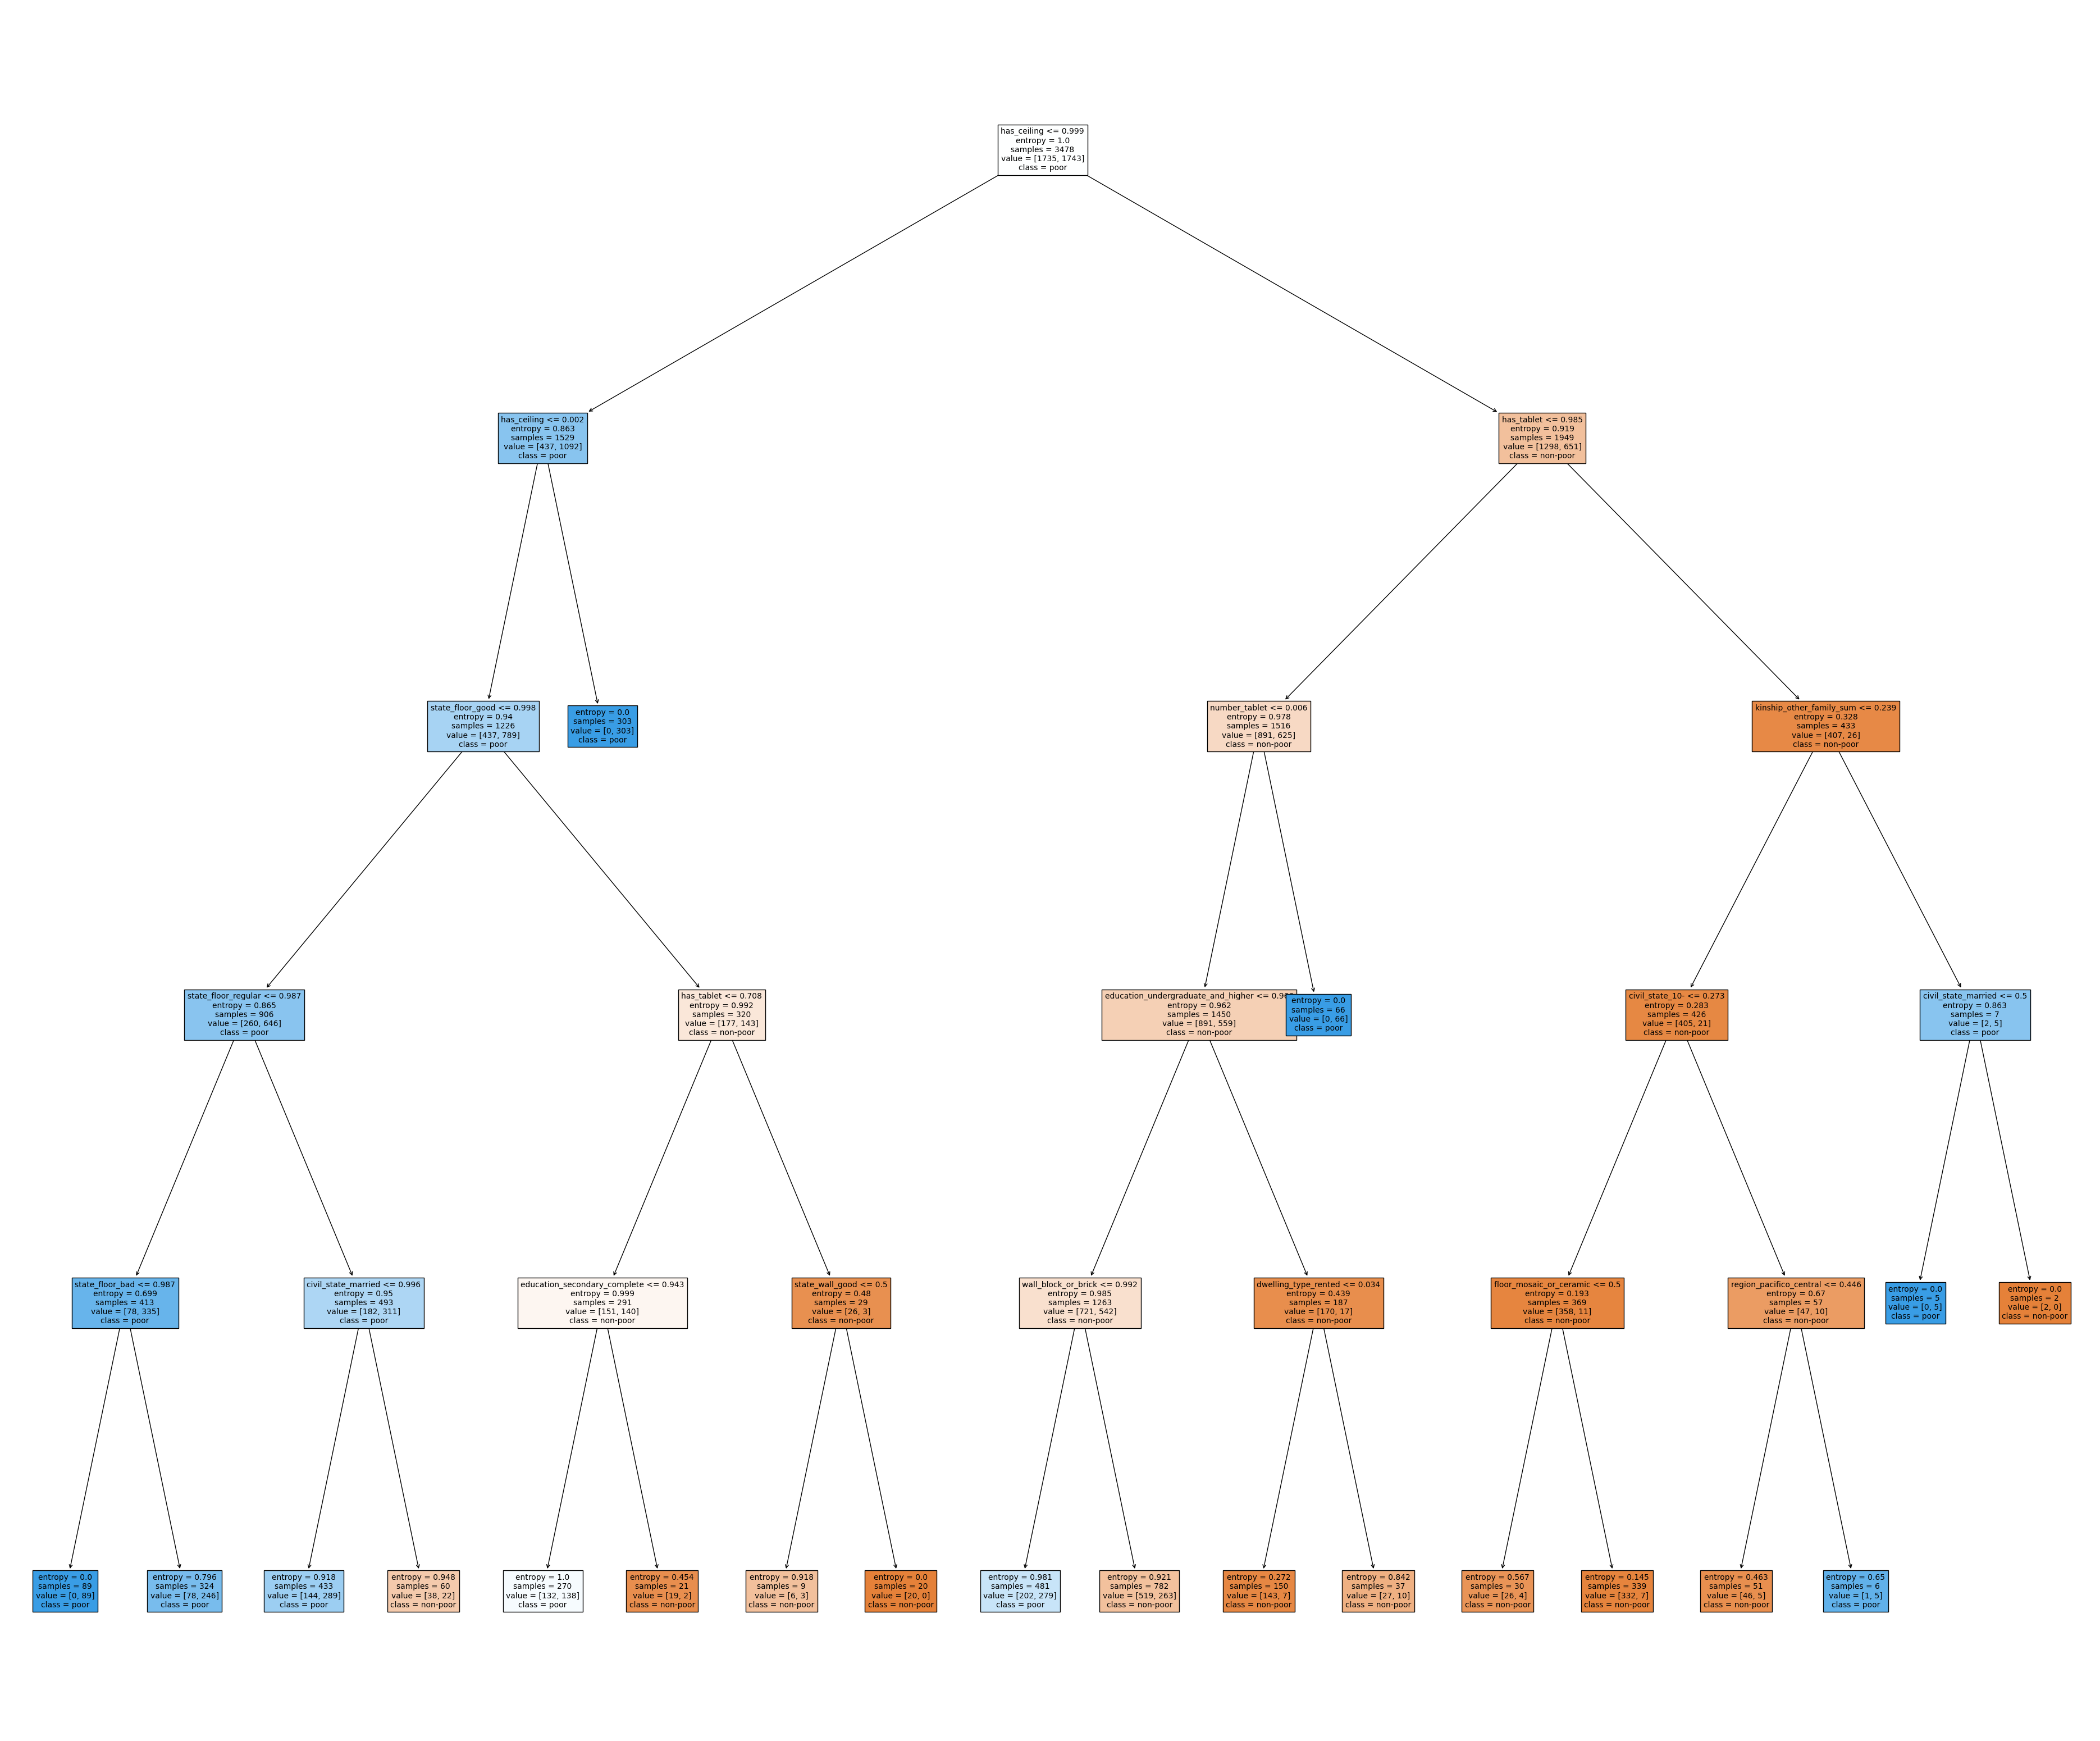

In [55]:
fig = plt.figure(figsize=(48, 40))
_ = plot_tree(tree_relief,
              feature_names=X_train_relief.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [56]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_relief{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Wrapper

### Select features

In [57]:
if RUN_WRAPPER_SELECTION:
    tree_wrapper = DecisionTreeClassifier()

    tree_fs_wrapper = SequentialFeatureSelectorTransformer(
        tree_wrapper, n_features_to_select=75)

    print('Fitting model. This may take a while...')
    X_tree_wrapper = tree_fs_wrapper.fit_transform(X_all, y['y'])
    print('We have a winner!')

    X_train_tree_wrapper, X_test_tree_wrapper, y_train_tree_wrapper, y_test_tree_wrapper = split_train_test(X_tree_wrapper, y)
    X_tree_wrapper.to_parquet(STAGE_DIR / 'selection' / f'X_train_tree{SUFIX}.parquet')

### Training and score in the sample (79% - 0.01 std)

In [58]:
if not RUN_WRAPPER_SELECTION:
    X_tree_wrapper = pd.read_parquet(STAGE_DIR / 'selection' / f'X_train_tree{SUFIX}.parquet')
    X_train_tree_wrapper, X_test_tree_wrapper, y_train_tree_wrapper, y_test_tree_wrapper = split_train_test(X_tree_wrapper, y)

In [59]:
X_tree_wrapper.columns.difference(X_svm_wrapper.columns)

Index(['civil_state_divorced', 'cook_energy_no',
       'dwelling_type_own_and_paying', 'dwelling_type_precarious',
       'education_postgraduate', 'education_secondary_technical_incomplete',
       'electricity_cooperative', 'electricity_public', 'female_12-',
       'floor_natural_material', 'floor_no', 'floor_other', 'has_tablet',
       'has_toilet', 'is_overcrowd_by_rooms', 'kinship_not_family_sum',
       'kinship_parent_in_low_sum', 'kinship_parent_sum',
       'kinship_sibling_sum', 'kinship_stepchildren_sum', 'region_chorotega',
       'region_pacifico_central', 'roof_fiber_cement_or_mezzanine',
       'roof_metal_zink', 'roof_natural_fibers', 'roof_other',
       'rubbish_disposal_other', 'rubbish_disposal_throw_unoccupied_space',
       'state_floor_bad', 'toilet_no', 'toilet_other', 'wall_natural_fibers',
       'wall_other', 'wall_socket', 'wall_waste_material', 'wall_zink',
       'water_inside_dwelling', 'water_no'],
      dtype='object')

In [60]:
tree_wrapper = DecisionTreeClassifier(**tree_parameters)
tree_wrapper_scores = cross_val_score(
    tree_wrapper,
    X_train_tree_wrapper,
    y_train_tree_wrapper['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    tree_wrapper_scores.mean(),
    tree_wrapper_scores.std())
)

0.75 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [61]:
tree_wrapper = DecisionTreeClassifier(**tree_parameters).fit(X_train_tree_wrapper, y_train_tree_wrapper['y'])
y_test_predict_tree_wrapper = tree_wrapper.predict(X_test_tree_wrapper)

print(classification_report(y_test_tree_wrapper['y'], y_test_predict_tree_wrapper))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       581
           1       0.80      0.65      0.72       579

    accuracy                           0.74      1160
   macro avg       0.75      0.74      0.74      1160
weighted avg       0.75      0.74      0.74      1160



### Tree structure

In [62]:
tree_structure(tree_wrapper, X_train_tree_wrapper.columns.values)

The binary tree structure has 41 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, has_tablet] <= 0.9881279170513153 else to node 24.
	node=1 is a split node: go to node 2 if X[:, female_12-] <= 0.0002534154336899519 else to node 15.
		node=2 is a split node: go to node 3 if X[:, bedrooms_number] <= 0.28533245623111725 else to node 8.
			node=3 is a split node: go to node 4 if X[:, bedrooms_number] <= 0.1429583579301834 else to node 7.
				node=4 is a split node: go to node 5 if X[:, kinship_children_sum] <= 0.0010919759515672922 else to node 6.
					node=5 is a leaf node.
					node=6 is a leaf node.
				node=7 is a leaf node.
			node=8 is a split node: go to node 9 if X[:, dwelling_type_own_and_paying] <= 0.5 else to node 12.
				node=9 is a split node: go to node 10 if X[:, has_tablet] <= 0.006464754696935415 else to node 11.
					node=10 is a leaf node.
					node=11 is a leaf node.
				node=12 is a split node: go to node 13 if X[:, region_paci

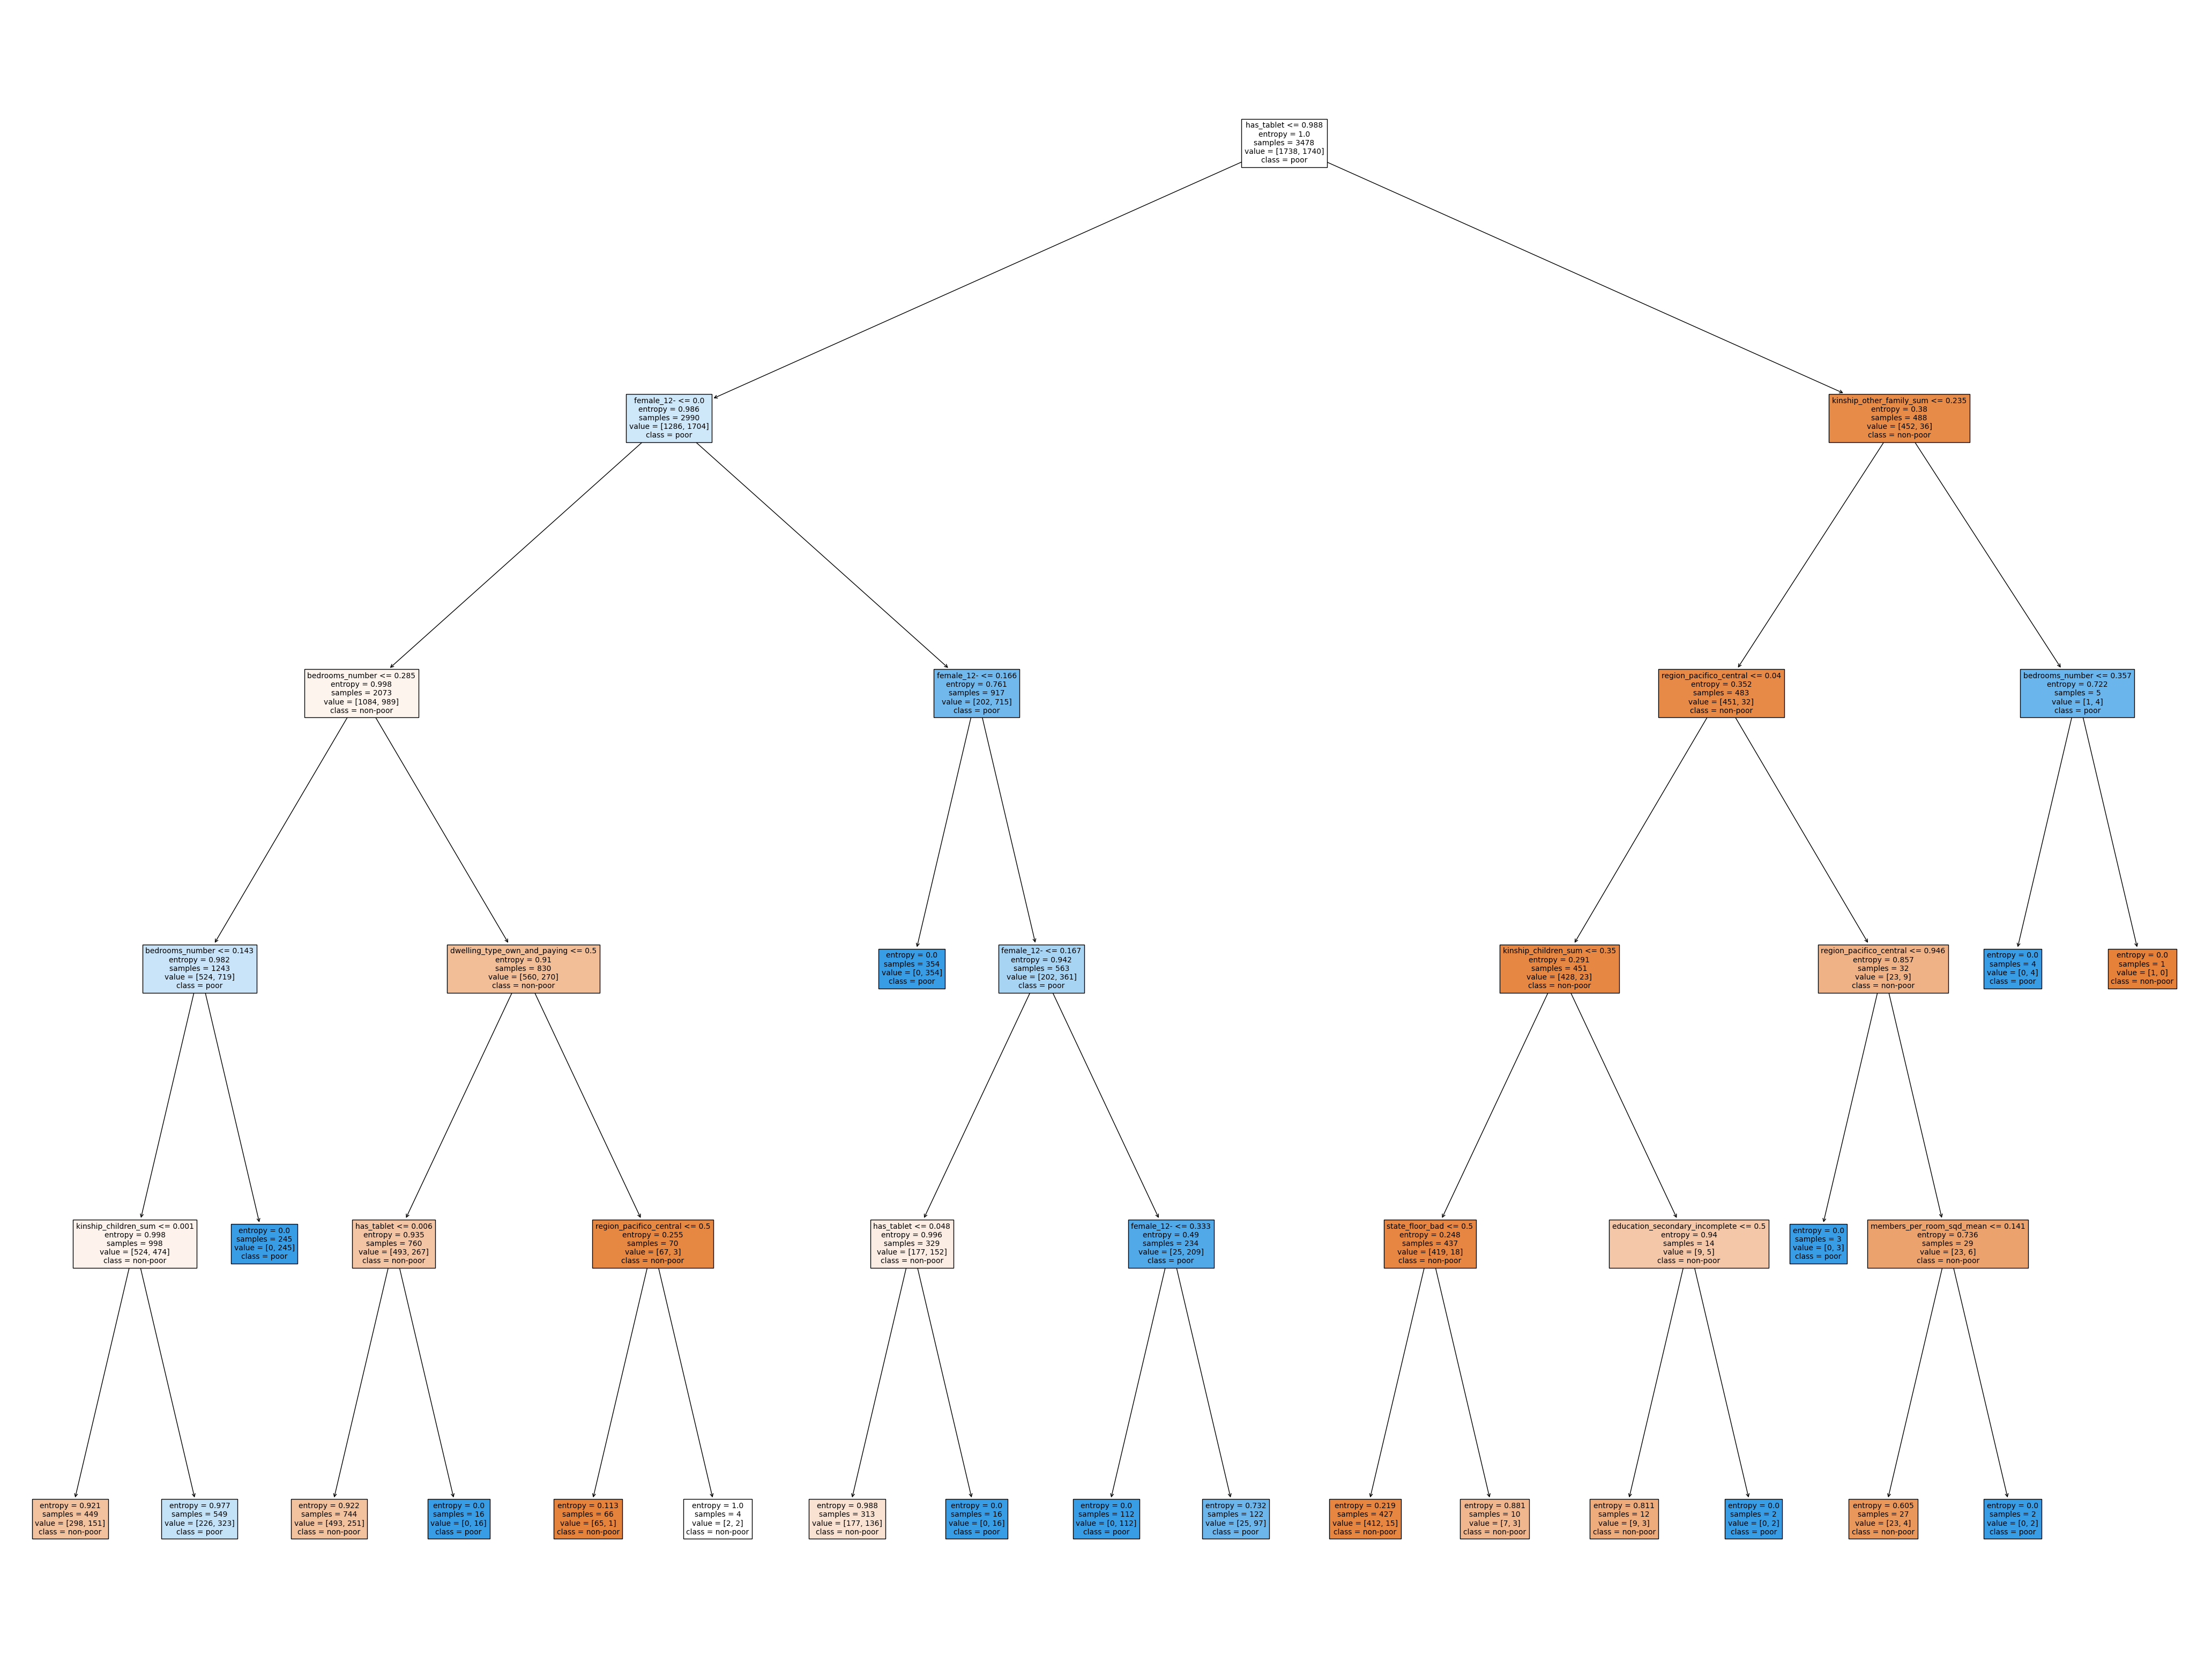

In [63]:
fig = plt.figure(figsize=(53, 40))
_ = plot_tree(tree_wrapper,
              feature_names=X_train_tree_wrapper.columns,  
              class_names=['non-poor', 'poor'],
              filled=True,
              fontsize=10)

In [64]:
fig.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'tree_wrapper{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Metrics summary

In [65]:
y_true_prediction_tree = [
    (y_test_all, y_test_predict_tree_all),
    (y_test_mi, y_test_predict_tree_mi),
    (y_test_x2, y_test_predict_tree_x2),
    (y_test_anova, y_test_predict_tree_anova),
    (y_test_relief, y_test_predict_tree_relief),
    (y_test_tree_wrapper, y_test_predict_tree_wrapper),
]

metrics_tree_summary = pd.DataFrame(
    [precision_recall_fscore_support(y_true, y_predict, average='macro')[:-1]
     for y_true, y_predict in y_true_prediction_tree],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Precision', 'Recall', 'F-score'
    ]
)

metrics_tree_summary

Precision    Recall   F-score
All features         0.768915  0.768883  0.768897
Mutual information   0.786883  0.786783  0.786828
Chi squared          0.755540  0.755139  0.755068
ANOVA                0.782417  0.782801  0.782525
RELIEF               0.740121  0.736634  0.735350
Wrapper              0.752562  0.743806  0.741685

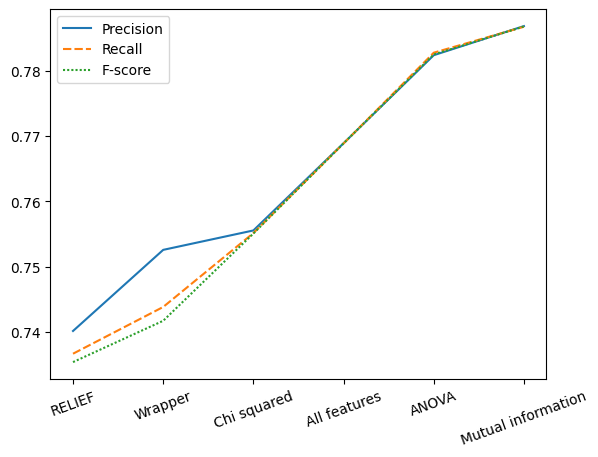

In [66]:
sns.lineplot(
    metrics_tree_summary.sort_values(['Precision', 'Recall', 'F-score']),
)
plt.xticks(rotation=20)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'metrics' / f'metrics_tree{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [120]:
accuracy_tree_summary = pd.DataFrame(
    [accuracy_score(y_true, y_predict)
     for y_true, y_predict in y_true_prediction_tree],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Accuracy'
    ]
) * 100

print(accuracy_tree_summary.round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Accuracy \\
\midrule
All features       &     76.90 \\
Mutual information &     78.71 \\
Chi squared        &     75.52 \\
ANOVA              &     78.28 \\
RELIEF             &     73.62 \\
Wrapper            &     74.40 \\
\bottomrule
\end{tabular}



C:\Users\gabya\AppData\Local\Temp\ipykernel_26580\1030693384.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(accuracy_tree_summary.round(2).to_latex())


# Rule Induction - RIPPER

The RIPPER algorithm builds a set of rules given a training data. We use the default parameters. The in-sample scores are calculated using a cross validation method with 5 folds. The accuracy is used as the metric to evaluate the model performance. 

## All features

### Training and score in the sample (78% - 0.00 std)

In [67]:
ripper_all = RIPPER()
ripper_all_scores = cross_val_score(
    ripper_all,
    X_train_all,
    y_train_all['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_all_scores.mean(),
    ripper_all_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

0.77 accuracy with a standard deviation of 0.02


### Out-of-sample score

In [68]:
ripper_all = RIPPER()
ripper_all.fit(X_train_all, y_train_all['y'])
y_test_predict_ripper_all = ripper_all.predict(X_test_all)

print(classification_report(y_test_all['y'], y_test_predict_ripper_all))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.67      0.98      0.79       571
           1       0.96      0.52      0.68       589

    accuracy                           0.75      1160
   macro avg       0.81      0.75      0.73      1160
weighted avg       0.81      0.75      0.73      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))


### Ruleset

In [69]:
ripper_all.out_model()

[[state_wall_good=<0.63 ^ male_12-=0.00403-0.199] V
[has_ceiling=<0.64 ^ mobile_phone_number=0.1-0.182] V
[has_ceiling=<0.64 ^ mobile_phone_number=0.201-0.3] V
[state_roof_good=<0.9 ^ state_roof_regular=<0.69 ^ is_disable_sum=0.11-0.33] V
[state_floor_good=<0.1 ^ scholarship_years=<0.13 ^ male_12-=>0.2] V
[state_wall_good=<0.63 ^ has_television=<0.97 ^ female_12+=0.2-0.33] V
[state_roof_good=<0.9 ^ adults_number_mean=0.13-0.22] V
[has_tablet=<0.1 ^ has_ceiling=<0.64 ^ female_12-=>0.17 ^ kinship_partner_sum=<0.23] V
[state_wall_good=<0.63 ^ has_television=<0.97 ^ adults_number_mean=0.25-0.33] V
[has_tablet=<0.1 ^ male_head_education_years=0.14-0.26 ^ female_12-=0.021-0.17] V
[has_tablet=<0.1 ^ members_per_room_sqd_mean=0.077-0.11 ^ male_12+=0.12-0.21] V
[mobile_phone_number=0.201-0.3] V
[wall_block_or_brick=<0.1 ^ male_head_education_years=<0.035 ^ dependency_rate=0.229-0.375 ^ state_wall_regular=<0.1] V
[has_tablet=<0.1 ^ dependency_rate=0.153-0.229 ^ children_19-_sqd_mean=0.049-0.11 ^

## Univariate - Mutual Information

### Training and score in the sample (79% - 0.01 std)

In [70]:
ripper_mi = RIPPER()
ripper_mi_scores = cross_val_score(
    ripper_mi,
    X_train_mi,
    y_train_mi['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_mi_scores.mean(),
    ripper_mi_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

nan accuracy with a standard deviation of nan


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\ripper.py", line 190, in fit
    ) = preprocess.preprocess_training_data(preprocess_params)
  File "c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\preprocess.py", line 57, in p

### Out-of-sample score

In [71]:
ripper_mi = RIPPER()
ripper_mi.fit(X_train_mi, y_train_mi['y'])
y_test_predict_ripper_mi = ripper_mi.predict(X_test_mi)

print(classification_report(y_test_mi['y'], y_test_predict_ripper_mi))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       598
           1       0.92      0.57      0.70       562

    accuracy                           0.77      1160
   macro avg       0.81      0.76      0.76      1160
weighted avg       0.81      0.77      0.76      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Ruleset

In [72]:
ripper_mi.out_model()

[[state_roof_good=<0.91 ^ mobile_phone_number=0.1-0.181] V
[state_wall_good=<0.5 ^ mobile_phone_number=0.201-0.3] V
[has_ceiling=<0.58 ^ male_12+=<0.12 ^ rural=<0.5] V
[has_ceiling=<0.58 ^ head_education_sqd=0.023-0.077 ^ number_rooms=0.2-0.3] V
[has_ceiling=<0.58 ^ male_12+=0.125-0.202] V
[state_roof_good=<0.91 ^ scholarship_years=<0.14 ^ mobile_phone_number=<0.1 ^ member_65+_mean=<0.33 ^ scholarship_years_sqd_mean=<0.035] V
[state_wall_good=<0.5 ^ kinship_children_sum=0.2-0.3] V
[state_roof_good=<0.91 ^ children_19-_sqd_mean=>0.11 ^ kinship_children_sum=>0.3 ^ member_12-=>0.29] V
[education_primary_incomplete=>0.6 ^ adults_number_mean=0.25-0.33] V
[has_ceiling=<0.58 ^ dependency_rate=0.235-0.375 ^ number_rooms=0.3-0.36] V
[state_roof_good=<0.91 ^ female_12-=0.017-0.17 ^ female_12+=0.22-0.33] V
[education_undergraduate_and_higher=<0.1 ^ has_television=<0.87 ^ dependency_rate=0.0632-0.122 ^ adults_number_mean=0.22-0.25] V
[has_television=<0.87 ^ education_undergraduate_and_higher=<0.1 

## Univariate - $\chi^2$

### Training and score in the sample (78% - 0.02 std)

In [73]:
ripper_x2 = RIPPER()
ripper_x2_scores = cross_val_score(
    ripper_x2,
    X_train_x2,
    y_train_x2['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_x2_scores.mean(),
    ripper_x2_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

0.70 accuracy with a standard deviation of 0.02


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Out-of-sample score

In [74]:
ripper_x2 = RIPPER()
ripper_x2.fit(X_train_x2, y_train_x2['y'])
y_test_predict_ripper_x2 = ripper_x2.predict(X_test_x2)

print(classification_report(y_test_x2['y'], y_test_predict_ripper_x2))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.57      0.96      0.71       581
           1       0.86      0.26      0.40       579

    accuracy                           0.61      1160
   macro avg       0.71      0.61      0.56      1160
weighted avg       0.71      0.61      0.56      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Ruleset

In [75]:
ripper_x2.out_model()

[[has_ceiling=<0.55 ^ state_wall_good=<0.55 ^ male_head_education_years=0.038-0.14] V
[wall_block_or_brick=<0.87 ^ state_roof_good=<0.77 ^ state_roof_regular=<0.83 ^ scholarship_years=<0.13 ^ children_19-_mean=0.222-0.333] V
[has_ceiling=<0.55 ^ male_head_education_years=<0.038 ^ scholarship_years=<0.13 ^ state_wall_bad=>0.9 ^ cook_energy_electricity=<0.1] V
[state_wall_good=<0.55 ^ has_television=<0.8 ^ head_education_sqd=0.022-0.07 ^ state_roof_regular=<0.83] V
[wall_block_or_brick=<0.87 ^ state_roof_good=<0.77 ^ state_roof_regular=<0.83 ^ state_roof_bad=<0.1] V
[wall_block_or_brick=<0.87 ^ wall_prefabricated_or_cement=<0.78 ^ head_education_sqd=0.0033-0.022 ^ has_ceiling=>0.55] V
[has_ceiling=<0.55 ^ scholarship_years_sqd_mean=0.054-0.071 ^ head_education_sqd=0.022-0.07 ^ wall_prefabricated_or_cement=<0.78] V
[state_wall_good=<0.55 ^ has_television=<0.8 ^ education_no=>0.9 ^ member_12-=>0.29] V
[has_ceiling=<0.55 ^ male_head_education_years=<0.038 ^ scholarship_years_sqd_mean=0.036-

## Univariate - ANOVA

### Training and score in the sample (79% - 0.01 std)

In [76]:
ripper_anova = RIPPER()
ripper_anova_scores = cross_val_score(
    ripper_anova,
    X_train_anova,
    y_train_anova['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_mi_scores.mean(),
    ripper_mi_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

nan accuracy with a standard deviation of nan


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Out-of-sample score

In [77]:
ripper_anova = RIPPER()
ripper_anova.fit(X_train_anova, y_train_anova['y'])
y_test_predict_ripper_anova = ripper_anova.predict(X_test_anova)

print(classification_report(y_test_anova['y'], y_test_predict_ripper_anova))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.68      0.96      0.79       555
           1       0.94      0.58      0.72       605

    accuracy                           0.76      1160
   macro avg       0.81      0.77      0.76      1160
weighted avg       0.81      0.76      0.75      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Ruleset

In [78]:
ripper_anova.out_model()

[[has_ceiling=<0.7 ^ mobile_phone_number=0.1-0.18] V
[state_wall_good=<0.75 ^ mobile_phone_number=0.2-0.3] V
[state_roof_good=<0.83 ^ state_roof_regular=<0.69 ^ is_disable_sum=0.11-0.33] V
[has_ceiling=<0.7 ^ tenenment_size=0.143-0.211] V
[state_roof_good=<0.83 ^ state_roof_regular=<0.69 ^ female_12-=0.016-0.17 ^ male_head_education_years=<0.038 ^ state_wall_good=<0.75] V
[state_roof_good=<0.83 ^ scholarship_years=<0.14 ^ female_12-=>0.17 ^ children_19-_sqd_mean=0.049-0.11] V
[state_roof_good=<0.83 ^ wall_block_or_brick=<0.1 ^ scholarship_years=<0.14 ^ scholarship_years_sqd_mean=<0.036 ^ rural=<0.55] V
[state_roof_good=<0.83 ^ head_education_sqd=0.024-0.076 ^ education_primary_incomplete=<0.64] V
[state_wall_good=<0.75 ^ head_education_sqd=0.0029-0.024 ^ male_head_education_years=0.038-0.14 ^ state_floor_regular=>0.2] V
[has_ceiling=<0.7 ^ female_12-=>0.17] V
[has_ceiling=<0.7 ^ adults_number_mean=0.25-0.33] V
[state_roof_good=<0.83 ^ adults_number_mean=0.14-0.22] V
[has_tablet=<0.1 ^ 

## Multivariate - Relief

### Training and score in the sample (77% - 0.01 std)

In [79]:
ripper_relief = RIPPER()
ripper_relief_scores = cross_val_score(
    ripper_relief,
    X_train_relief,
    y_train_relief['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_relief_scores.mean(),
    ripper_relief_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

0.65 accuracy with a standard deviation of 0.02


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Out-of-sample score

In [80]:
ripper_relief = RIPPER()
ripper_relief.fit(X_train_relief, y_train_relief['y'])
y_test_predict_ripper_relief = ripper_relief.predict(X_test_relief)

print(classification_report(y_test_relief['y'], y_test_predict_ripper_relief))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.59      0.91      0.71       584
           1       0.79      0.35      0.49       576

    accuracy                           0.63      1160
   macro avg       0.69      0.63      0.60      1160
weighted avg       0.69      0.63      0.60      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Ruleset

In [81]:
ripper_relief.out_model()

[[state_wall_good=<0.49 ^ has_ceiling=<0.56 ^ is_disable_sum=0.1-0.33] V
[state_wall_good=<0.49 ^ has_television=<0.85 ^ state_roof_regular=<0.7 ^ state_roof_good=<0.76 ^ member_65+_mean=<0.33 ^ rural=<0.82] V
[has_ceiling=<0.56 ^ state_wall_good=<0.49 ^ dwelling_type_own_and_paid=>0.9 ^ region_brunca=>0.58 ^ state_roof_regular=>0.7] V
[has_ceiling=<0.56 ^ education_primary_complete=<0.93 ^ has_television=<0.85 ^ region_chorotega=>0.33 ^ kinship_grandchildren_sum=<0.12 ^ wall_block_or_brick=<0.1] V
[state_roof_good=<0.76 ^ civil_state_single=<0.81 ^ has_television=<0.85 ^ state_roof_regular=<0.7 ^ dwelling_type_own_and_paid=>0.9] V
[has_ceiling=<0.56 ^ toilet_septic_tank=>0.24 ^ education_primary_incomplete=>0.69 ^ rubbish_disposal_burning=<0.67] V
[has_tablet=<0.1 ^ cook_energy_gas=>0.17 ^ has_television=<0.85 ^ is_disable_sum=0.1-0.33] V
[state_wall_good=<0.49 ^ has_television=<0.85 ^ education_no=>0.9 ^ has_ceiling=>0.56 ^ toilet_septic_tank=>0.24 ^ region_chorotega=<0.33]]


## Wrapper

### Select features

In [82]:
if RUN_WRAPPER_SELECTION:
    ripper_wrapper = RIPPER()

    ripper_fs_wrapper = SequentialFeatureSelectorTransformer(
        ripper_wrapper, n_features_to_select=75)

    print('Fitting model. This may take a while...')
    X_ripper_wrapper = ripper_fs_wrapper.fit_transform(X_all, y['y'])
    print('We have a winner!')

    X_train_ripper_wrapper, X_test_ripper_wrapper, y_train_ripper_wrapper, y_test_ripper_wrapper = split_train_test(X_ripper_wrapper, y)
    X_ripper_wrapper.to_parquet(STAGE_DIR / 'selection' / f'X_train_ripper{SUFIX}.parquet')

### Training and score in the sample (78% - 0.00 std)

In [83]:
if not RUN_WRAPPER_SELECTION:
    X_ripper_wrapper = pd.read_parquet(STAGE_DIR / 'selection' / f'X_train_ripper{SUFIX}.parquet')
    X_train_ripper_wrapper, X_test_ripper_wrapper, y_train_ripper_wrapper, y_test_ripper_wrapper = split_train_test(X_ripper_wrapper, y)

In [84]:
ripper_wrapper = RIPPER()
ripper_wrapper_scores = cross_val_score(
    ripper_wrapper,
    X_train_ripper_wrapper,
    y_train_ripper_wrapper['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ripper_wrapper_scores.mean(),
    ripper_wrapper_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

0.77 accuracy with a standard deviation of 0.03


### Out-of-sample score

In [85]:
ripper_wrapper = RIPPER()
ripper_wrapper.fit(X_train_ripper_wrapper, y_train_ripper_wrapper['y'])
y_test_predict_ripper_wrapper = ripper_wrapper.predict(X_test_ripper_wrapper)

print(classification_report(y_test_ripper_wrapper['y'], y_test_predict_ripper_wrapper))

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       591
           1       0.98      0.50      0.66       569

    accuracy                           0.75      1160
   macro avg       0.83      0.75      0.73      1160
weighted avg       0.82      0.75      0.73      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\wittgenstein\base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

### Ruleset

In [86]:
ripper_wrapper.out_model()

[[wall_block_or_brick=<0.98 ^ male_12-=0.01519-0.1997] V
[wall_block_or_brick=<0.98 ^ is_disable_sum=0.1-0.33] V
[wall_block_or_brick=<0.98 ^ mobile_phone_number=0.1-0.18] V
[mobile_phone_number=0.203-0.3] V
[wall_block_or_brick=<0.98 ^ dependency_rate=0.23-0.375 ^ wall_socket=<0.36 ^ civil_state_10-=>0.9] V
[wall_block_or_brick=<0.98 ^ has_tablet=<0.1 ^ male_12-=>0.2] V
[has_tablet=<0.1 ^ adults_number_mean=0.14-0.22] V
[wall_block_or_brick=<0.98 ^ scholarship_years_sqd_mean=<0.036 ^ education_years_mean_18+=0.095-0.14] V
[has_tablet=<0.1 ^ wall_block_or_brick=<0.98 ^ adults_number_mean=0.26-0.33]]


## Metrics summary

In [87]:
y_true_prediction_ripper = [
    (y_test_all, y_test_predict_ripper_all),
    (y_test_mi, y_test_predict_ripper_mi),
    (y_test_x2, y_test_predict_ripper_x2),
    (y_test_anova, y_test_predict_ripper_anova),
    (y_test_relief, y_test_predict_ripper_relief),
    (y_test_ripper_wrapper, y_test_predict_ripper_wrapper),
]

metrics_ripper_summary = pd.DataFrame(
    [precision_recall_fscore_support(y_true, y_predict, average='macro')[:-1]
     for y_true, y_predict in y_true_prediction_ripper],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Precision', 'Recall', 'F-score'
    ]
)

metrics_ripper_summary

Precision    Recall   F-score
All features         0.811064  0.750050  0.734412
Mutual information   0.810755  0.761286  0.755904
Chi squared          0.712871  0.610610  0.557840
ANOVA                0.809137  0.770263  0.756064
RELIEF               0.687385  0.629994  0.600540
Wrapper              0.827744  0.745331  0.731823

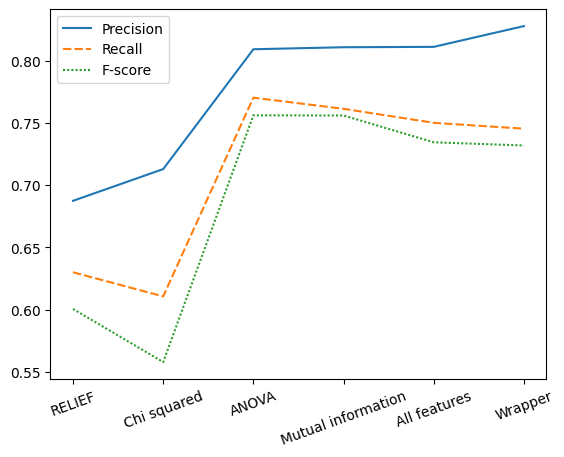

In [88]:
sns.lineplot(
    metrics_ripper_summary.sort_values(['Precision', 'Recall', 'F-score']),
)
plt.xticks(rotation=20)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'metrics' / f'metrics_ripper{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [119]:
accuracy_ripper_summary = pd.DataFrame(
    [accuracy_score(y_true, y_predict)
     for y_true, y_predict in y_true_prediction_ripper],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Accuracy'
    ]
) * 100

print(accuracy_ripper_summary.round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Accuracy \\
\midrule
All features       &     74.66 \\
Mutual information &     76.72 \\
Chi squared        &     61.12 \\
ANOVA              &     76.21 \\
RELIEF             &     63.19 \\
Wrapper            &     75.00 \\
\bottomrule
\end{tabular}



C:\Users\gabya\AppData\Local\Temp\ipykernel_26580\2615966313.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(accuracy_ripper_summary.round(2).to_latex())


# K-Nearest Neighbors

Text(0, 0.5, 'Accuracy Score')

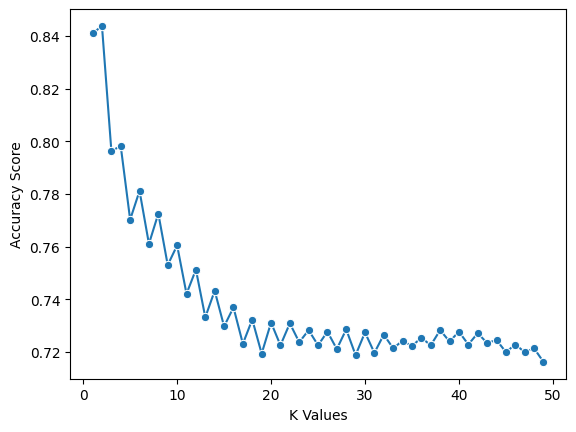

In [107]:
k_values = [i for i in range (1, 50)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_all, y_train_all['y'], cv=5)
    scores.append(np.mean(score))

sns.lineplot(x=k_values, y=scores, marker='o')
plt.xlabel('K Values')
plt.ylabel('Accuracy Score')
plt.savefig(
    ANALYSIS_DIR / 'images' / 'non-probabilistic-models' / f'knn_best_k{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [108]:
k = np.argmax(scores)
k

1

## All features

### Training and score in the sample (79% - 0.00 std)

In [91]:
knn_all = KNeighborsClassifier(n_neighbors=k)
knn_all_scores = cross_val_score(
    knn_all,
    X_train_all,
    y_train_all['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_all_scores.mean(),
    knn_all_scores.std())
)

0.84 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [92]:
knn_all = KNeighborsClassifier(n_neighbors=k)
knn_all.fit(X_train_all, y_train_all['y'])
y_test_predict_knn_all = knn_all.predict(X_test_all)

print(classification_report(y_test_all['y'], y_test_predict_knn_all))

              precision    recall  f1-score   support

           0       0.98      0.68      0.81       571
           1       0.76      0.99      0.86       589

    accuracy                           0.84      1160
   macro avg       0.87      0.84      0.84      1160
weighted avg       0.87      0.84      0.84      1160



## Univariate - Mutual Information

### Training and score in the sample (77% - 0.00 std)

In [93]:
knn_mi = KNeighborsClassifier(n_neighbors=k)
knn_mi_scores = cross_val_score(
    knn_mi,
    X_train_mi,
    y_train_mi['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_mi_scores.mean(),
    knn_mi_scores.std())
)

0.84 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [94]:
knn_mi = KNeighborsClassifier(n_neighbors=k)
knn_mi.fit(X_train_mi, y_train_mi['y'])
y_test_predict_knn_mi = knn_mi.predict(X_test_mi)

print(classification_report(y_test_mi['y'], y_test_predict_knn_mi))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       598
           1       0.76      0.99      0.86       562

    accuracy                           0.84      1160
   macro avg       0.87      0.85      0.84      1160
weighted avg       0.88      0.84      0.84      1160



## Univariate - $\chi^2$

### Training and score in the sample (78% - 0.01 std)

In [95]:
knn_x2 = KNeighborsClassifier(n_neighbors=k)
knn_x2_scores = cross_val_score(
    knn_x2,
    X_train_x2,
    y_train_x2['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_x2_scores.mean(),
    knn_x2_scores.std())
)

0.81 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [96]:
knn_x2 = KNeighborsClassifier(n_neighbors=k)
knn_x2.fit(X_train_x2, y_train_x2['y'])
y_test_predict_knn_x2 = knn_x2.predict(X_test_x2)

print(classification_report(y_test_x2['y'], y_test_predict_knn_x2))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       581
           1       0.79      0.94      0.86       579

    accuracy                           0.85      1160
   macro avg       0.86      0.85      0.85      1160
weighted avg       0.86      0.85      0.85      1160



## Univariate - ANOVA

### Training and score in the sample (78% - 0.01 std)

In [97]:
knn_anova = KNeighborsClassifier(n_neighbors=k)
knn_anova_scores = cross_val_score(
    knn_anova,
    X_train_anova,
    y_train_anova['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_anova_scores.mean(),
    knn_anova_scores.std())
)

0.84 accuracy with a standard deviation of 0.00


### Out-of-sample score

In [98]:
knn_anova = KNeighborsClassifier(n_neighbors=k)
knn_anova.fit(X_train_anova, y_train_anova['y'])
y_test_predict_knn_anova = knn_anova.predict(X_test_anova)

print(classification_report(y_test_anova['y'], y_test_predict_knn_anova))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       555
           1       0.81      0.99      0.89       605

    accuracy                           0.87      1160
   macro avg       0.90      0.87      0.87      1160
weighted avg       0.89      0.87      0.87      1160



## Multivariate - Relief

### Training and score in the sample (77% - 0.01 std)

In [99]:
knn_relief = KNeighborsClassifier(n_neighbors=k)
knn_relief_scores = cross_val_score(
    knn_relief,
    X_train_relief,
    y_train_relief['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_relief_scores.mean(),
    knn_relief_scores.std())
)

0.82 accuracy with a standard deviation of 0.00


### Out-of-sample score

In [100]:
knn_relief = KNeighborsClassifier(n_neighbors=k)
knn_relief.fit(X_train_relief, y_train_relief['y'])
y_test_predict_knn_relief = knn_relief.predict(X_test_relief)

print(classification_report(y_test_relief['y'], y_test_predict_knn_relief))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       584
           1       0.77      0.98      0.86       576

    accuracy                           0.84      1160
   macro avg       0.87      0.84      0.84      1160
weighted avg       0.87      0.84      0.84      1160



## Wrapper

### Select features

In [101]:
if RUN_WRAPPER_SELECTION:
    knn_wrapper = KNeighborsClassifier(n_neighbors=k)

    knn_fs_wrapper = SequentialFeatureSelectorTransformer(
        knn_wrapper, n_features_to_select=75)

    print('Fitting model. This may take a while...')
    X_knn_wrapper = knn_fs_wrapper.fit_transform(X_all, y['y'])
    print('We have a winner!')

    X_train_knn_wrapper, X_test_knn_wrapper, y_train_knn_wrapper, y_test_knn_wrapper = split_train_test(X_knn_wrapper, y)
    X_knn_wrapper.to_parquet(STAGE_DIR / 'selection' / f'X_train_knn{SUFIX}.parquet')

### Training and score in the sample (80% - 0.01 std)

In [102]:
if not RUN_WRAPPER_SELECTION:
    X_knn_wrapper = pd.read_parquet(STAGE_DIR / 'selection' / f'X_train_knn{SUFIX}.parquet')
    X_train_knn_wrapper, X_test_knn_wrapper, y_train_knn_wrapper, y_test_knn_wrapper = split_train_test(X_knn_wrapper, y)

In [103]:
knn_wrapper = KNeighborsClassifier(n_neighbors=k)
knn_wrapper_scores = cross_val_score(
    knn_wrapper,
    X_train_knn_wrapper,
    y_train_knn_wrapper['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    knn_wrapper_scores.mean(),
    knn_wrapper_scores.std())
)

0.85 accuracy with a standard deviation of 0.01


### Out-of-sample score

In [104]:
knn_wrapper = KNeighborsClassifier(n_neighbors=k)
knn_wrapper.fit(X_train_knn_wrapper, y_train_knn_wrapper['y'])
y_test_predict_knn_wrapper = knn_wrapper.predict(X_test_knn_wrapper)

print(classification_report(y_test_knn_wrapper['y'], y_test_predict_knn_wrapper))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       568
           1       0.83      0.94      0.88       592

    accuracy                           0.87      1160
   macro avg       0.88      0.87      0.87      1160
weighted avg       0.88      0.87      0.87      1160



## Metrics summary

In [105]:
y_true_prediction_knn = [
    (y_test_all, y_test_predict_knn_all),
    (y_test_mi, y_test_predict_knn_mi),
    (y_test_x2, y_test_predict_knn_x2),
    (y_test_anova, y_test_predict_knn_anova),
    (y_test_relief, y_test_predict_knn_relief),
    (y_test_knn_wrapper, y_test_predict_knn_wrapper),
]

metrics_knn_summary = pd.DataFrame(
    [precision_recall_fscore_support(y_true, y_predict, average='macro')[:-1]
     for y_true, y_predict in y_true_prediction_knn],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Precision', 'Recall', 'F-score'
    ]
)

metrics_knn_summary

Precision    Recall   F-score
All features         0.874488  0.837288  0.835139
Mutual information   0.871780  0.848234  0.842012
Chi squared          0.857995  0.846706  0.845356
ANOVA                0.895156  0.865386  0.867277
RELIEF               0.872169  0.844915  0.841203
Wrapper              0.877497  0.868362  0.868793

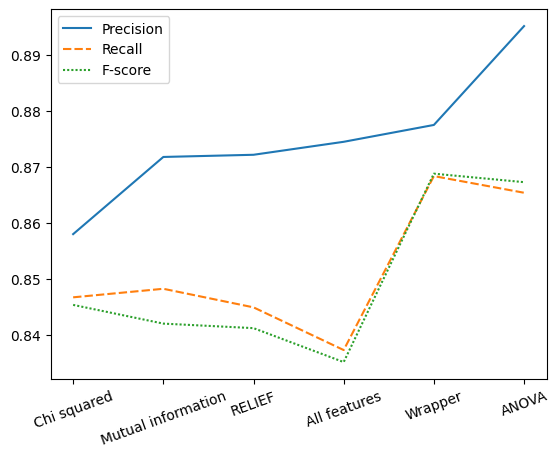

In [106]:
sns.lineplot(
    metrics_knn_summary.sort_values(['Precision', 'Recall', 'F-score']),
)
plt.xticks(rotation=20)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'metrics' / f'metrics_knn{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [115]:
accuracy_knn_summary = pd.DataFrame(
    [accuracy_score(y_true, y_predict)
     for y_true, y_predict in y_true_prediction_knn],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Accuracy'
    ]
) * 100

print(accuracy_knn_summary.round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Accuracy \\
\midrule
All features       &     83.97 \\
Mutual information &     84.40 \\
Chi squared        &     84.66 \\
ANOVA              &     87.07 \\
RELIEF             &     84.40 \\
Wrapper            &     86.98 \\
\bottomrule
\end{tabular}



C:\Users\gabya\AppData\Local\Temp\ipykernel_26580\1955284381.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(accuracy_knn_summary.round(2).to_latex())


# Artificial Neural Networks

In [128]:
ann_parameters = {
    'max_iter': 400
}

## All features

### Training and score in the sample (79% - 0.00 std)

In [129]:
ann_all = MLPClassifier(**ann_parameters)
ann_all_scores = cross_val_score(
    ann_all,
    X_train_all,
    y_train_all['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_all_scores.mean(),
    ann_all_scores.std())
)

0.88 accuracy with a standard deviation of 0.02


### Out-of-sample score

In [130]:
ann_all = MLPClassifier(**ann_parameters)
ann_all.fit(X_train_all, y_train_all['y'])
y_test_predict_ann_all = ann_all.predict(X_test_all)

print(classification_report(y_test_all['y'], y_test_predict_ann_all))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       571
           1       0.86      0.96      0.91       589

    accuracy                           0.90      1160
   macro avg       0.90      0.90      0.90      1160
weighted avg       0.90      0.90      0.90      1160



## Univariate - Mutual Information

### Training and score in the sample (79% - 0.00 std)

In [131]:
ann_mi = MLPClassifier(**ann_parameters)
ann_mi_scores = cross_val_score(
    ann_mi,
    X_train_mi,
    y_train_mi['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_mi_scores.mean(),
    ann_mi_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.88 accuracy with a standard deviation of 0.01


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Out-of-sample score

In [133]:
ann_mi = MLPClassifier(**ann_parameters)
ann_mi.fit(X_train_mi, y_train_mi['y'])
y_test_predict_ann_mi = ann_mi.predict(X_test_mi)

print(classification_report(y_test_mi['y'], y_test_predict_ann_mi))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       598
           1       0.84      0.96      0.89       562

    accuracy                           0.89      1160
   macro avg       0.89      0.89      0.89      1160
weighted avg       0.90      0.89      0.89      1160



## Univariate - $\chi^2$

### Training and score in the sample (79% - 0.00 std)

In [134]:
ann_x2 = MLPClassifier(**ann_parameters)
ann_x2_scores = cross_val_score(
    ann_x2,
    X_train_x2,
    y_train_x2['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_x2_scores.mean(),
    ann_x2_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.82 accuracy with a standard deviation of 0.02


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Out-of-sample score

In [135]:
ann_x2 = MLPClassifier(**ann_parameters)
ann_x2.fit(X_train_x2, y_train_x2['y'])
y_test_predict_ann_x2 = ann_x2.predict(X_test_x2)

print(classification_report(y_test_x2['y'], y_test_predict_ann_x2))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       581
           1       0.84      0.90      0.87       579

    accuracy                           0.87      1160
   macro avg       0.87      0.87      0.87      1160
weighted avg       0.87      0.87      0.87      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


## Univariate - ANOVA

### Training and score in the sample (79% - 0.00 std)

In [136]:
ann_anova = MLPClassifier(**ann_parameters)
ann_anova_scores = cross_val_score(
    ann_anova,
    X_train_anova,
    y_train_anova['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_anova_scores.mean(),
    ann_anova_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.88 accuracy with a standard deviation of 0.01


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Out-of-sample score

In [137]:
ann_anova = MLPClassifier(**ann_parameters)
ann_anova.fit(X_train_anova, y_train_anova['y'])
y_test_predict_ann_anova = ann_anova.predict(X_test_anova)

print(classification_report(y_test_anova['y'], y_test_predict_ann_anova))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       555
           1       0.86      0.95      0.91       605

    accuracy                           0.90      1160
   macro avg       0.90      0.89      0.90      1160
weighted avg       0.90      0.90      0.90      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


## Multivariate - Relief

### Training and score in the sample (79% - 0.00 std)

In [138]:
ann_relief = MLPClassifier(**ann_parameters)
ann_relief_scores = cross_val_score(
    ann_relief,
    X_train_relief,
    y_train_relief['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_relief_scores.mean(),
    ann_relief_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.86 accuracy with a standard deviation of 0.01


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Out-of-sample score

In [139]:
ann_relief = MLPClassifier(**ann_parameters)
ann_relief.fit(X_train_relief, y_train_relief['y'])
y_test_predict_ann_relief = ann_relief.predict(X_test_relief)

print(classification_report(y_test_relief['y'], y_test_predict_ann_relief))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       584
           1       0.84      0.94      0.89       576

    accuracy                           0.88      1160
   macro avg       0.89      0.88      0.88      1160
weighted avg       0.89      0.88      0.88      1160



c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


## Wrapper

### Select features

In [141]:
if RUN_WRAPPER_SELECTION:
    ann_wrapper = MLPClassifier(**ann_parameters)

    ann_fs_wrapper = SequentialFeatureSelectorTransformer(
        ann_wrapper, n_features_to_select=75)

    print('Fitting model. This may take a while...')
    X_ann_wrapper = ann_fs_wrapper.fit_transform(X_train_anova, y_train_anova['y'])
    print('We have a winner!')

    X_train_ann_wrapper, X_test_ann_wrapper, y_train_ann_wrapper, y_test_ann_wrapper = split_train_test(X_ann_wrapper, y)
    X_ann_wrapper.to_parquet(STAGE_DIR / 'selection' / f'X_train_ann{SUFIX}.parquet')

Fitting model. This may take a while...


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users

### Training and score in the sample (79% - 0.00 std)

In [ ]:
ann_wrapper = MLPClassifier(**ann_parameters)
ann_wrapper_scores = cross_val_score(
    ann_wrapper,
    X_train_ann_wrapper,
    y_train_ann_wrapper['y'],
    cv=5
)

print("%0.2f accuracy with a standard deviation of %0.2f" % (
    ann_wrapper_scores.mean(),
    ann_wrapper_scores.std())
)

c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.88 accuracy with a standard deviation of 0.01


c:\Users\gabya\anaconda3\envs\project-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Out-of-sample score

In [ ]:
ann_wrapper = MLPClassifier(**ann_parameters)
ann_wrapper.fit(X_train_ann_wrapper, y_train_ann_wrapper['y'])
y_test_predict_ann_wrapper = ann_wrapper.predict(X_test_ann_wrapper)

print(classification_report(y_test_ann_wrapper['y'], y_test_predict_ann_wrapper))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       598
           1       0.84      0.96      0.89       562

    accuracy                           0.89      1160
   macro avg       0.89      0.89      0.89      1160
weighted avg       0.90      0.89      0.89      1160



## Metrics summary

In [ ]:
y_true_prediction_ann = [
    (y_test_all, y_test_predict_ann_all),
    (y_test_mi, y_test_predict_ann_mi),
    (y_test_x2, y_test_predict_ann_x2),
    (y_test_anova, y_test_predict_ann_anova),
    (y_test_relief, y_test_predict_ann_relief),
    (y_test_ann_wrapper, y_test_predict_ann_wrapper),
]

metrics_ann_summary = pd.DataFrame(
    [precision_recall_fscore_support(y_true, y_predict, average='macro')[:-1]
     for y_true, y_predict in y_true_prediction_ann],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Precision', 'Recall', 'F-score'
    ]
)

metrics_ann_summary

Precision    Recall   F-score
All features         0.874488  0.837288  0.835139
Mutual information   0.871780  0.848234  0.842012
Chi squared          0.857995  0.846706  0.845356
ANOVA                0.895156  0.865386  0.867277
RELIEF               0.872169  0.844915  0.841203
Wrapper              0.877497  0.868362  0.868793

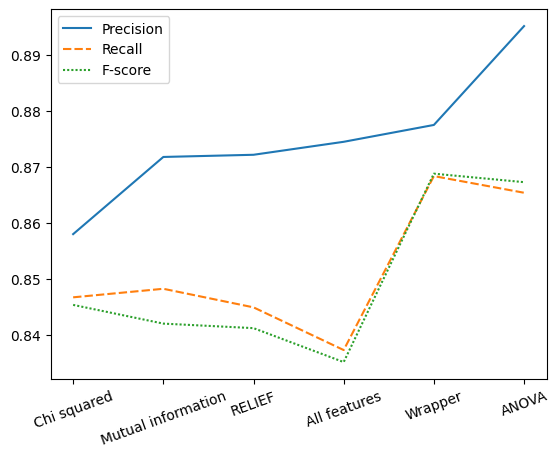

In [ ]:
sns.lineplot(
    metrics_ann_summary.sort_values(['Precision', 'Recall', 'F-score']),
)
plt.xticks(rotation=20)
plt.savefig(
    ANALYSIS_DIR / 'images' / 'metrics' / f'metrics_ann{SUFIX}.pdf',
    dpi=300,
    bbox_inches='tight'
)

In [ ]:
accuracy_ann_summary = pd.DataFrame(
    [accuracy_score(y_true, y_predict)
     for y_true, y_predict in y_true_prediction_ann],
    index=[
        'All features',
        'Mutual information',
        'Chi squared',
        'ANOVA',
        'RELIEF',
        'Wrapper',
    ],
    columns=[
        'Accuracy'
    ]
) * 100

print(accuracy_ann_summary.round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  Accuracy \\
\midrule
All features       &     83.97 \\
Mutual information &     84.40 \\
Chi squared        &     84.66 \\
ANOVA              &     87.07 \\
RELIEF             &     84.40 \\
Wrapper            &     86.98 \\
\bottomrule
\end{tabular}



C:\Users\gabya\AppData\Local\Temp\ipykernel_26580\1955284381.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(accuracy_knn_summary.round(2).to_latex())
